In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/New_Project

/content/drive/MyDrive/New_Project


In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from typing import Tuple, List, Set
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import gaussian_kde
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from numpy.random import seed
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**CNN Model Builder Function**

This function CNN is designed to build a Convolutional Neural Network (CNN) using Keras with a customizable architecture. It allows you to specify the configuration of the convolutional and dense layers dynamically.

Parameters:

* input_shape: A tuple that defines the shape of the input data. For Conv1D layers, this should be (time_steps, features).

* filters_in_convs: A list of integers where each integer specifies the number of filters in the corresponding Conv1D layer.

* kernels_sizes: A list of integers where each integer specifies the kernel size in the Conv1D layers.

* strides_sizes: A list of integers where each integer specifies the stride length in the Conv1D layers.

* neurons_in_denses: A list of integers where each integer specifies the number of neurons in the corresponding Dense layer after the Conv1D layers.

* activations: A list of strings, where each string is the activation function to be used in the Conv1D and Dense layers. The length of this list should be equal to the sum of the number of Conv1D and Dense layers.


Returns:
The function returns a keras.Sequential model with the specified architecture.

In [5]:
def CNN(input_shape: Tuple, filters_in_convs: List, kernels_sizes: List, strides_sizes: List,
                      neurons_in_denses: List, activations: List) -> keras.Sequential:

  count = len(filters_in_convs)
  activation_count = 1
  model = Sequential()
  model.add(Conv1D(filters = filters_in_convs[0], kernel_size = kernels_sizes[0], strides = strides_sizes[0],
                   activation=activations[0], input_shape = input_shape))
  for i in range(1, count):
    model.add(Conv1D(filters = filters_in_convs[i], kernel_size = kernels_sizes[i],
                     strides = strides_sizes[i], activation = activations[activation_count]))
  model.add(Flatten())
  count = len(neurons_in_denses)
  model.add(Dense(units=neurons_in_denses[0], activation = activations[activation_count]))
  for i in range(1, count):
    activation_count += 1
    model.add(Dense(units=neurons_in_denses[i], activation = activations[activation_count]))
  model.add(Dense(units=1, activation='linear'))
  return model

**Factorization of Categorical Columns Function**

This function, factorize_columns, is designed to encode categorical features into a numeric format within a DataFrame, storing the unique labels for each feature. This is often a necessary preprocessing step before feeding the data into machine learning models that require numerical input.

Parameters:

* dataset (pd.DataFrame): The DataFrame containing the data to be processed.

* target (str): The name of the target column. The function will only factorize columns that have a different data type than the target column.

Returns:

Tuple[pd.DataFrame, dict]: A tuple containing the transformed DataFrame and a dictionary of labels for all factorized columns.

In [6]:
def factorize_columns(dataset: pd.DataFrame, target: str) -> Tuple[pd.DataFrame, dict]:
  all_labels = {}
  for column in dataset.columns:
    if dataset[column].dtypes != dataset[target].dtypes:
      dataset[column], labels = pd.factorize(dataset[column])
      all_labels[column] = labels
  return dataset, all_labels

**Correlation Analysis Function**

The correlation function is used to calculate and analyze the correlation matrix of a given dataset. It also provides functionality to visualize and save the correlation matrix as a heatmap.

Parameters:

* dataset (pd.DataFrame): The dataset on which to perform correlation analysis.

* corr_method (str, default='kendall'): Specifies the method to use for computing correlation. Options are 'pearson', 'kendall', and 'spearman'.

* threshold (float, default=0.7): The cutoff value above which features are considered highly correlated.

* show (bool, default=True): Controls whether to display the heatmap in the output cell.

* fig_dims (Tuple[int, int], default=(12, 8)): Determines the size of the heatmap figure.

* isCbar (bool, default=True): Decides whether to display a color bar alongside the heatmap.

* save (bool, default=False): If true, the heatmap will be saved as an image file.

Returns:

Set[str]: A set of feature names that are highly correlated with at least one other feature, as determined by the threshold.

In [7]:
def correlation(dataset: pd.DataFrame, corr_method: str = 'kendall', threshold: float = 0.7, show: bool = True,
                fig_dims: Tuple[int, int] = (12, 8), isCbar: bool = True, save: bool = False) -> Set[str]:

    corr_features = set()
    corr_matrix = dataset.corr(method=corr_method)

    # Identify highly correlated features
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                corr_features.add(colname)

    # Display the heatmap
    if show:
        fig, ax = plt.subplots(figsize=fig_dims)
        sns.heatmap(corr_matrix, ax=ax, annot=True, cmap='coolwarm', cbar=isCbar)
        plt.title(f"Heatmap of Correlation Matrix Using {corr_method.capitalize()} Method")
        if save:
            plt.savefig("correlation_heatmap.png", dpi=300, format="png")
            plt.savefig("correlation_heatmap.tiff", dpi=300, format="tiff")
        plt.show()

    return corr_features

# Data Analysis and processing

In [8]:
# Loading the data
train_df = pd.read_parquet('train.parquet')
validation_df = pd.read_parquet('test.parquet')
target = "demand" #this is the target function that we aim to predict

In [9]:
train_df.head()

demand departure_date  destination_current_public_holiday  \
0       1     2019-03-01                                   0   
1       6     2019-03-01                                   0   
2       5     2019-03-01                                   0   
3       0     2019-03-01                                   0   
4       0     2019-03-01                                   0   

   destination_current_school_holiday  \
0                                   1   
1                                   1   
2                                   1   
3                                   1   
4                                   1   

   destination_days_to_next_public_holiday  \
0                                       52   
1                                       52   
2                                       52   
3                                       52   
4                                       52   

   destination_days_to_next_school_holiday destination_station_name  \
0                                      -13                       ag   
1                                      -13                       ag   
2                                      -13                       ag   
3                                      -13                       ag   
4                                      -13                       ag   

   od_destination_time  od_number_of_similar_12_hours  \
0                 1088                              5   
1                 1088                              5   
2                 1088                              5   
3                 1088                              5   
4                 1088                              5   

   od_number_of_similar_2_hours  ...  origin_days_to_next_school_holiday  \
0                             1  ...                                  -6   
1                             1  ...                                  -6   
2                             1  ...                                  -6   
3                             1  ...                                  -6   
4                             1  ...                                  -6   

   origin_station_name  price   sale_date  sale_day  sale_day_x  sale_month  \
0                  cpe  26.65  2018-12-02         2         -89          12   
1                  cpe  26.65  2018-12-03         3         -88          12   
2                  cpe  26.65  2018-12-04         4         -87          12   
3                  cpe  26.65  2018-12-05         5         -86          12   
4                  cpe  26.65  2018-12-06         6         -85          12   

   sale_week  sale_weekday  sale_year  
0          6             6       2018  
1          0             0       2018  
2          1             1       2018  
3          2             2       2018  
4          3             3       2018  

[5 rows x 30 columns]

In [10]:
# A concise summary of the dataframe
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632841 entries, 0 to 632840
Data columns (total 30 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   demand                                   632841 non-null  int64  
 1   departure_date                           632841 non-null  object 
 2   destination_current_public_holiday       632841 non-null  int64  
 3   destination_current_school_holiday       632841 non-null  int64  
 4   destination_days_to_next_public_holiday  632841 non-null  int64  
 5   destination_days_to_next_school_holiday  632841 non-null  int64  
 6   destination_station_name                 632841 non-null  object 
 7   od_destination_time                      632841 non-null  int64  
 8   od_number_of_similar_12_hours            632841 non-null  int64  
 9   od_number_of_similar_2_hours             632841 non-null  int64  
 10  od_number_of_similar_4_hours    

In [11]:
# Descriptive statistics
train_df.describe()

demand  destination_current_public_holiday  \
count  632841.000000                            632841.0   
mean        3.000149                                 0.0   
std         7.256572                                 0.0   
min         0.000000                                 0.0   
25%         0.000000                                 0.0   
50%         0.000000                                 0.0   
75%         3.000000                                 0.0   
max       192.000000                                 0.0   

       destination_current_school_holiday  \
count                       632841.000000   
mean                             0.362070   
std                              0.480599   
min                              0.000000   
25%                              0.000000   
50%                              0.000000   
75%                              1.000000   
max                              1.000000   

       destination_days_to_next_public_holiday  \
count                            632841.000000   
mean                                 33.468421   
std                                  20.902826   
min                                   0.000000   
25%                                  16.000000   
50%                                  32.000000   
75%                                  50.000000   
max                                  77.000000   

       destination_days_to_next_school_holiday  od_destination_time  \
count                            632841.000000        632841.000000   
mean                                  7.209680           917.638889   
std                                  28.727468           255.245208   
min                                 -58.000000           399.000000   
25%                                 -12.000000           698.000000   
50%                                  11.000000           964.000000   
75%                                  31.000000          1088.000000   
max                                  74.000000          1370.000000   

       od_number_of_similar_12_hours  od_number_of_similar_2_hours  \
count                  632841.000000                  632841.00000   
mean                        6.013457                       1.42268   
std                         2.383453                       1.35439   
min                        -1.000000                      -1.00000   
25%                         5.000000                       0.00000   
50%                         6.000000                       1.00000   
75%                         7.000000                       2.00000   
max                        10.000000                       4.00000   

       od_number_of_similar_4_hours  od_origin_month  ...  \
count                 632841.000000    632841.000000  ...   
mean                       2.577630         6.841843  ...   
std                        1.413168         2.656572  ...   
min                       -1.000000         2.000000  ...   
25%                        2.000000         5.000000  ...   
50%                        2.000000         7.000000  ...   
75%                        4.000000         9.000000  ...   
max                        7.000000        11.000000  ...   

       origin_current_school_holiday  origin_days_to_next_public_holiday  \
count                  632841.000000                       632841.000000   
mean                        0.380696                           33.468421   
std                         0.485558                           20.902826   
min                         0.000000                            0.000000   
25%                         0.000000                           16.000000   
50%                         0.000000                           32.000000   
75%                         1.000000                           50.000000   
max                         1.000000                           77.000000   

       origin_days_to_next_school_holiday          price       sale_day  \
count                       632841.

In [12]:
# Check for missing values
train_df.isnull().sum()

demand                                     0
departure_date                             0
destination_current_public_holiday         0
destination_current_school_holiday         0
destination_days_to_next_public_holiday    0
destination_days_to_next_school_holiday    0
destination_station_name                   0
od_destination_time                        0
od_number_of_similar_12_hours              0
od_number_of_similar_2_hours               0
od_number_of_similar_4_hours               0
od_origin_month                            0
od_origin_time                             0
od_origin_week                             0
od_origin_weekday                          0
od_origin_year                             0
od_travel_time_minutes                     0
origin_current_public_holiday              0
origin_current_school_holiday              0
origin_days_to_next_public_holiday         0
origin_days_to_next_school_holiday         0
origin_station_name                        0
price     

**Visualizing the Distribution of Numerical Features**

Numerical Columns:

A predefined list of column names is considered 'numerical', which includes features such as 'demand', 'destination days to next public holiday', etc.

Histograms:

For each numerical feature, a histogram is generated using Seaborn's histplot function. This function also overlays a Kernel Density Estimate (KDE) to show the smooth distribution curve of the data.

Goals of This Analysis:

* Data Cleaning: Identify features with anomalies or outliers that may require cleaning.
* Feature Engineering: Determine which transformations might be beneficial for normalizing data distributions.
* Model Preparation: Guide the choice of features to include in modeling and how to scale or preprocess them.

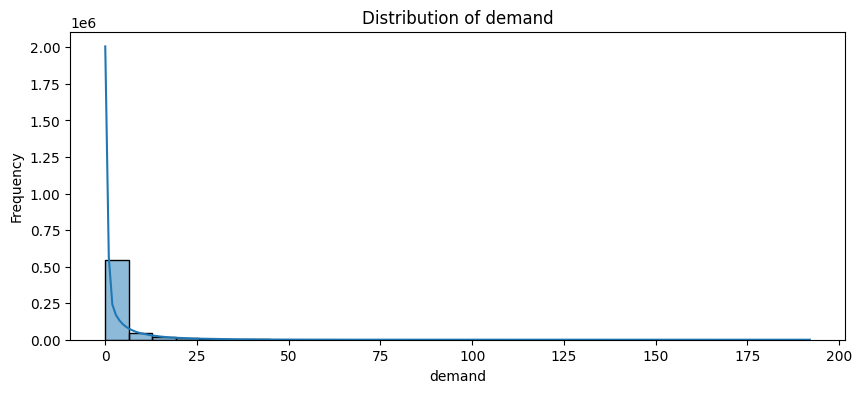

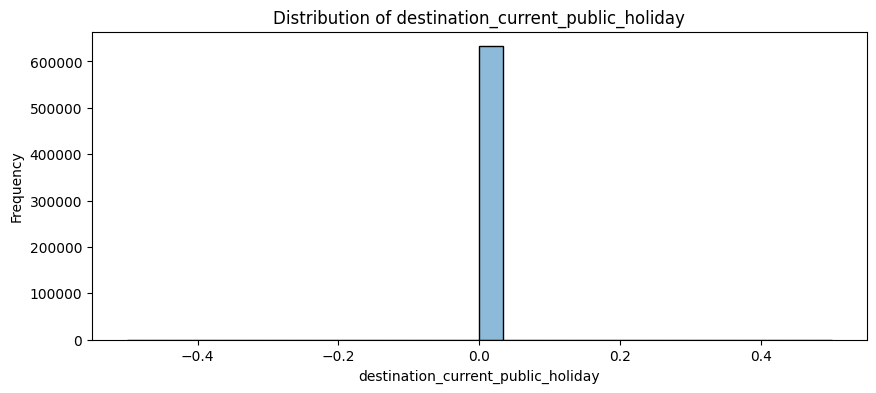

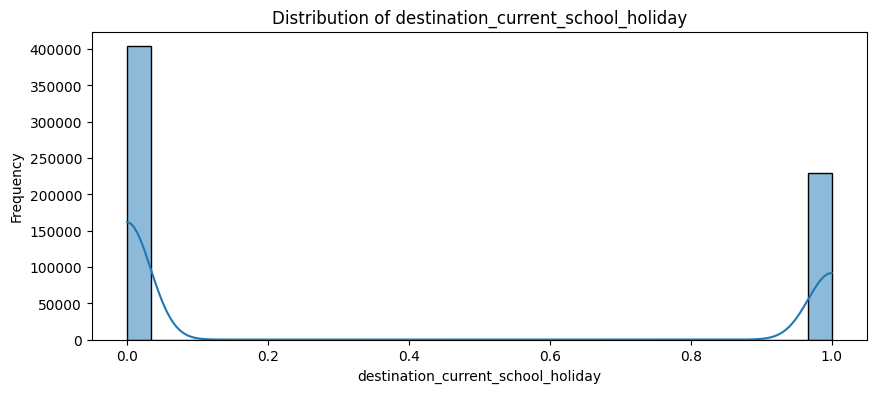

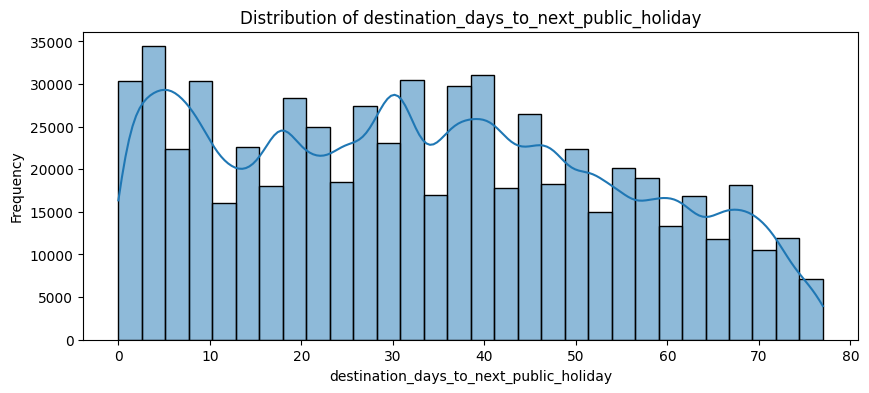

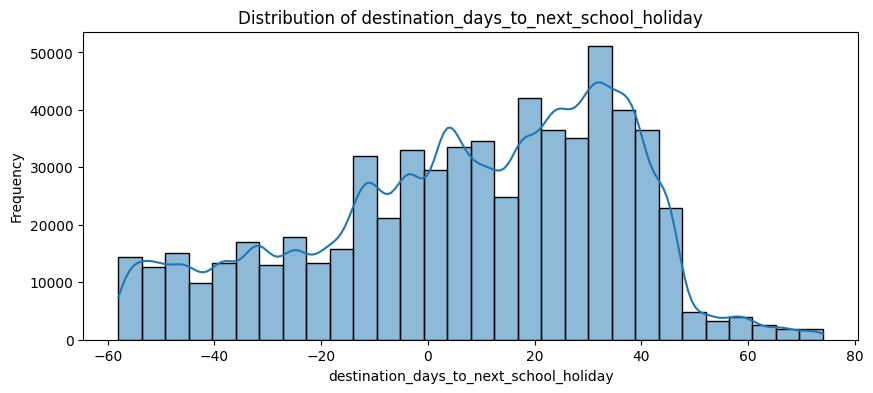

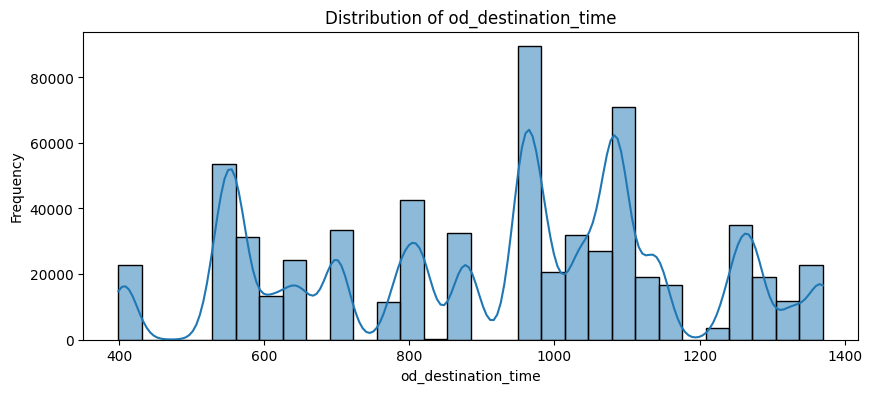

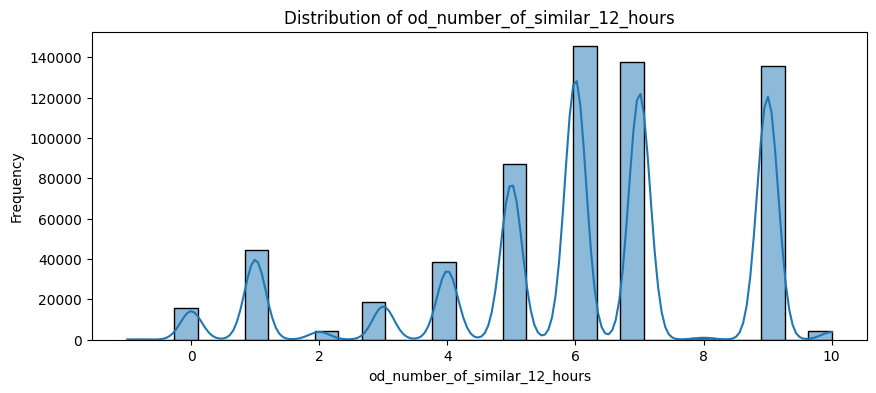

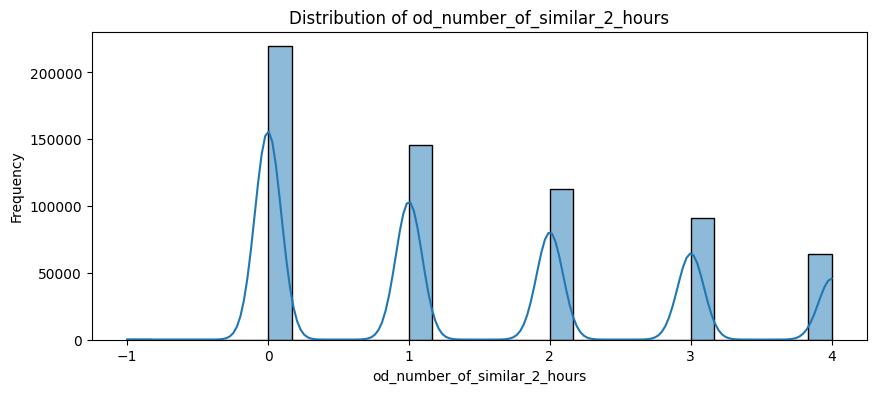

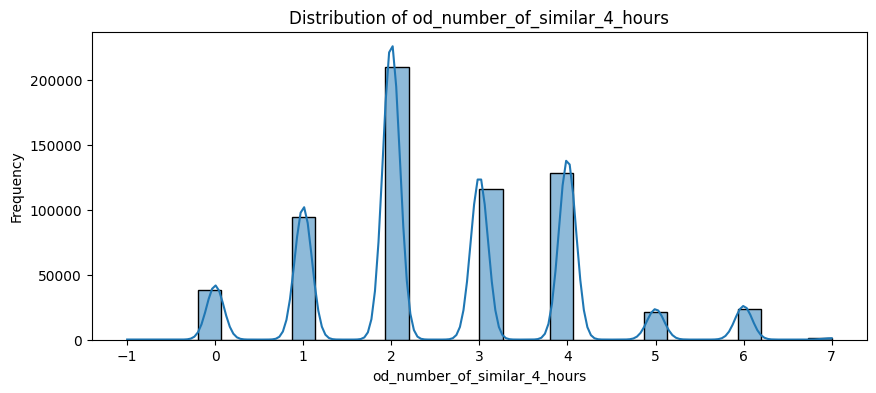

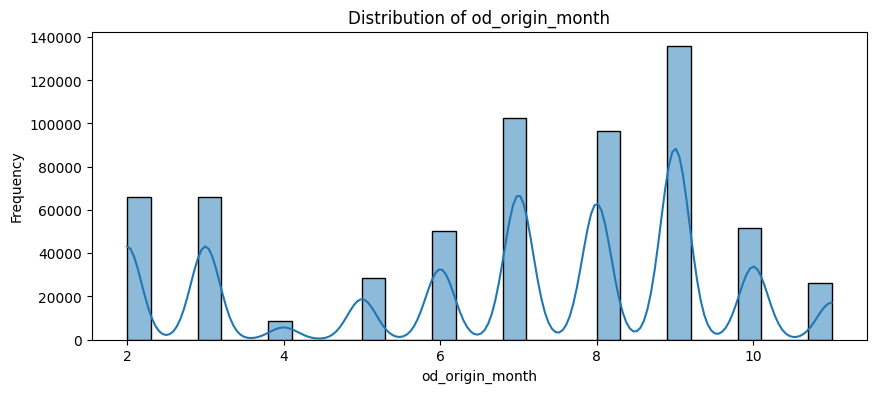

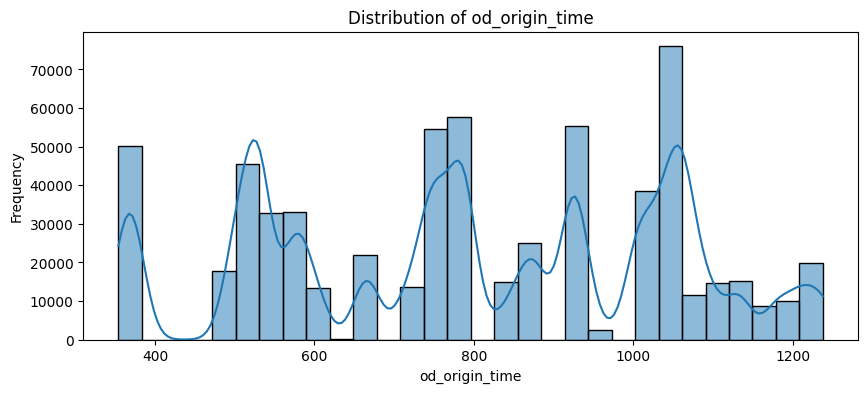

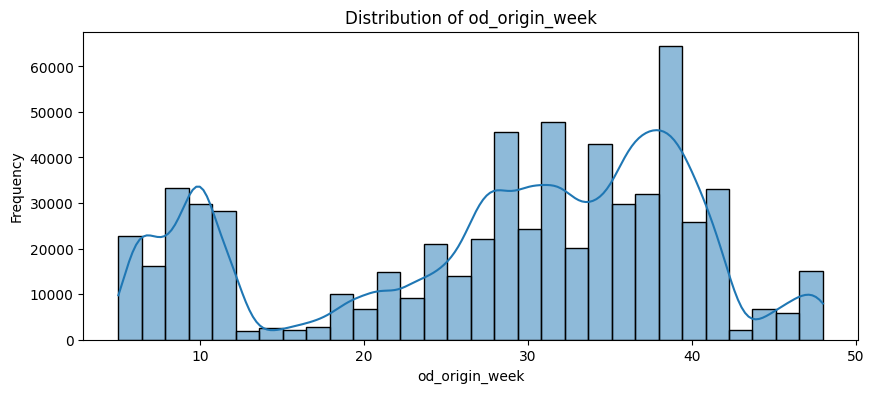

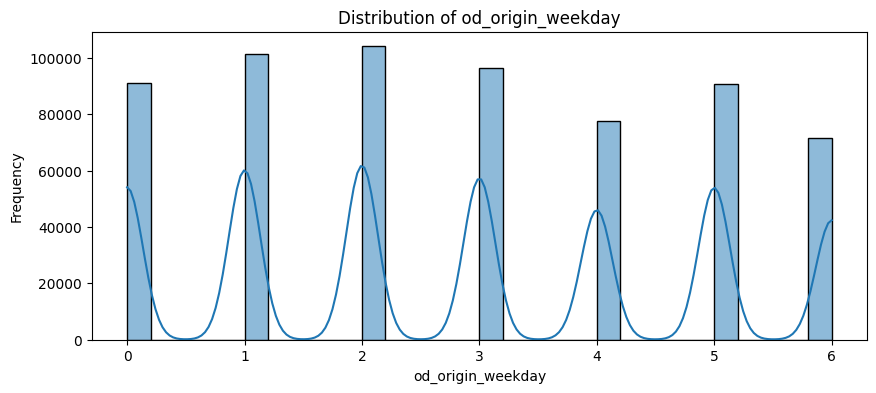

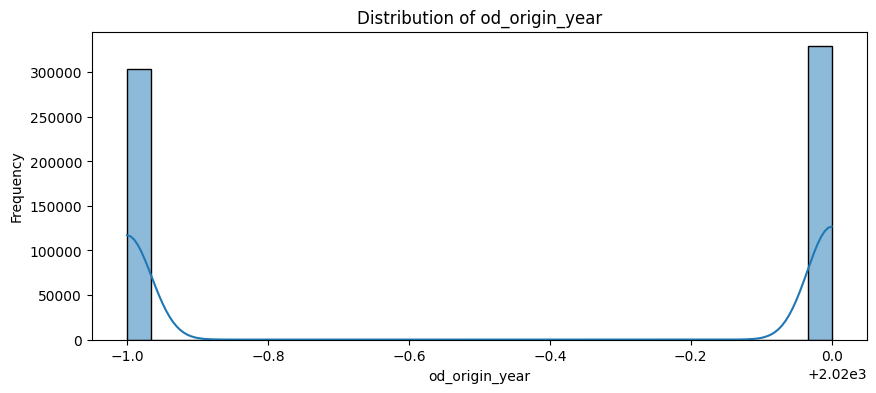

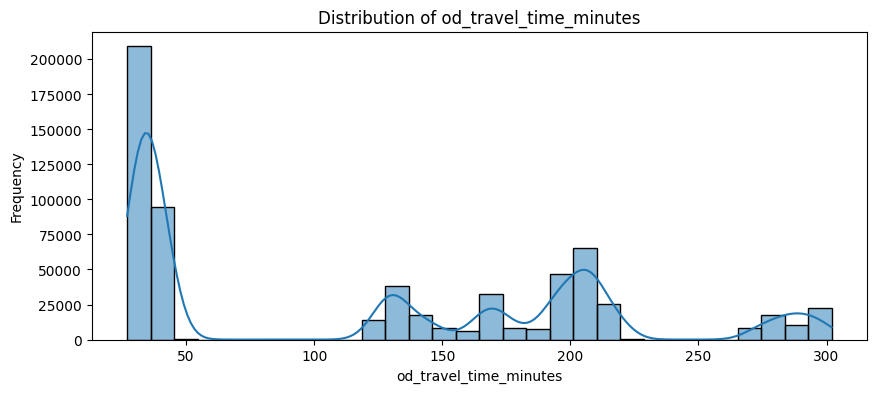

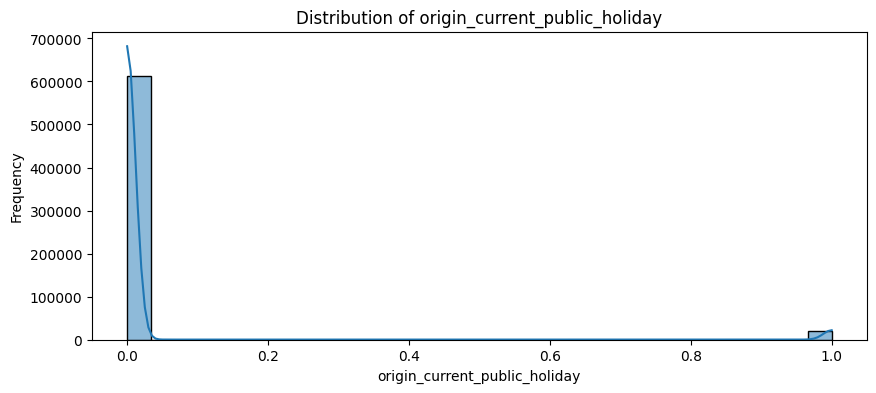

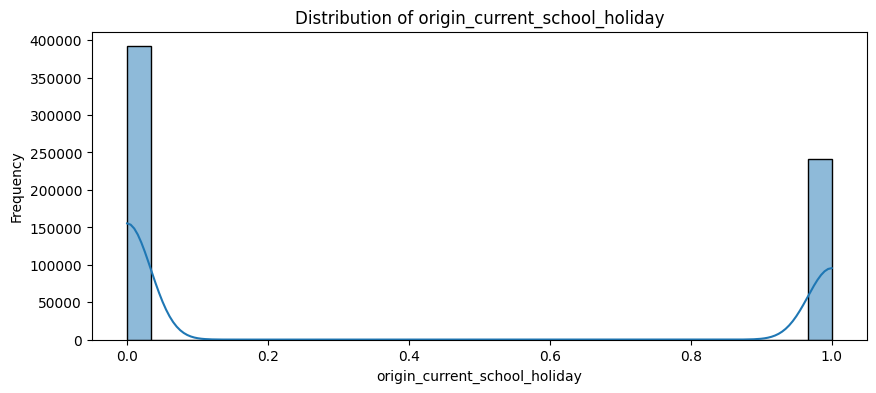

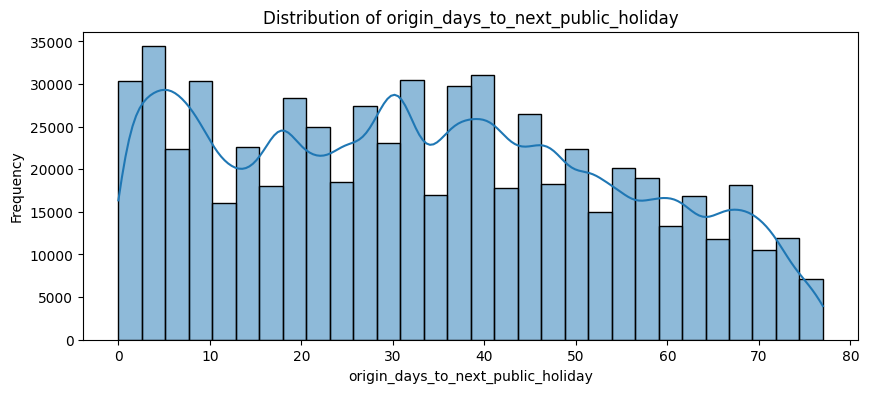

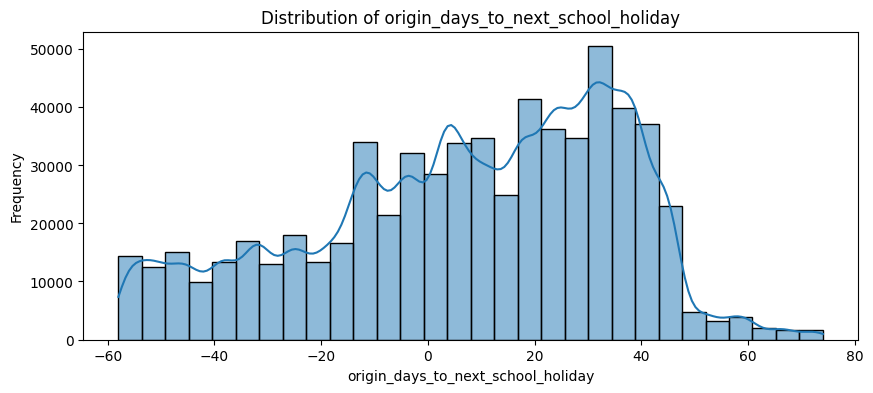

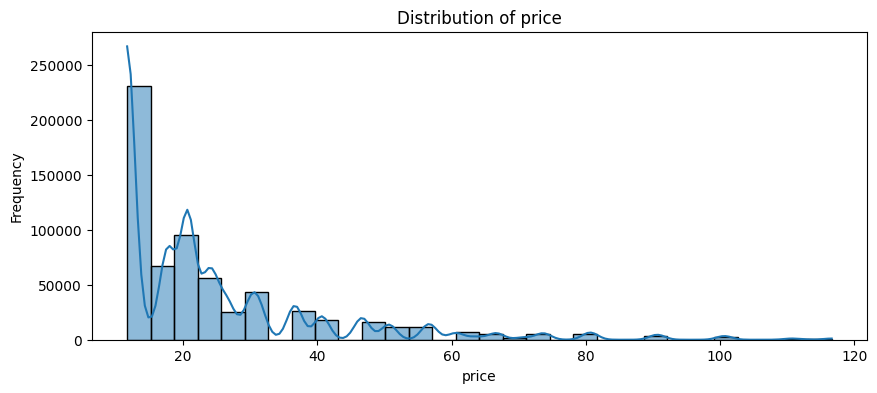

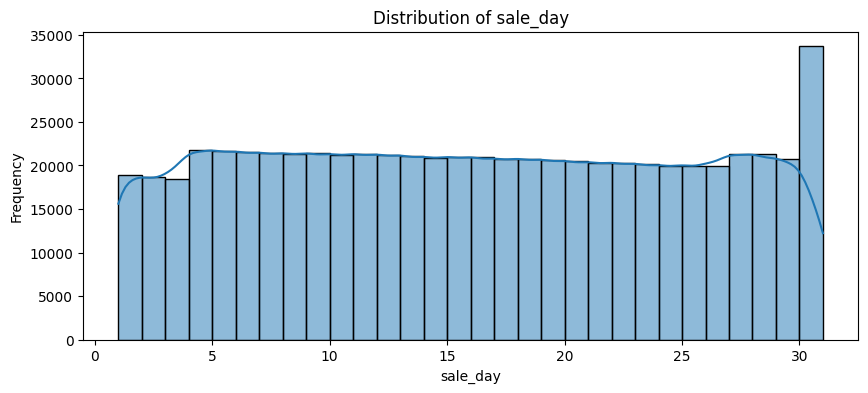

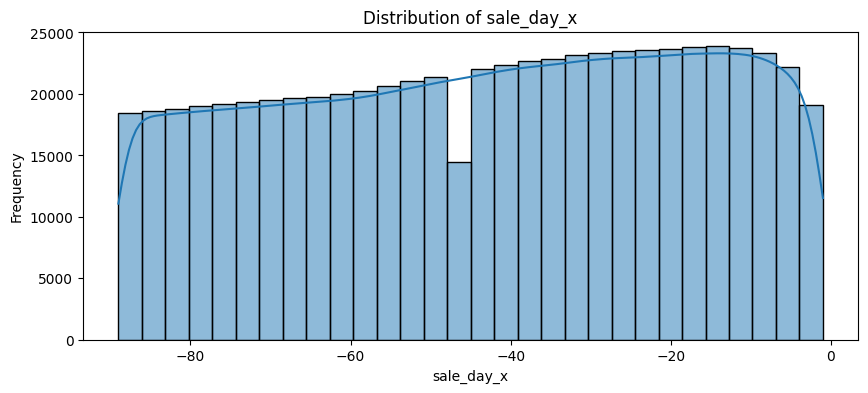

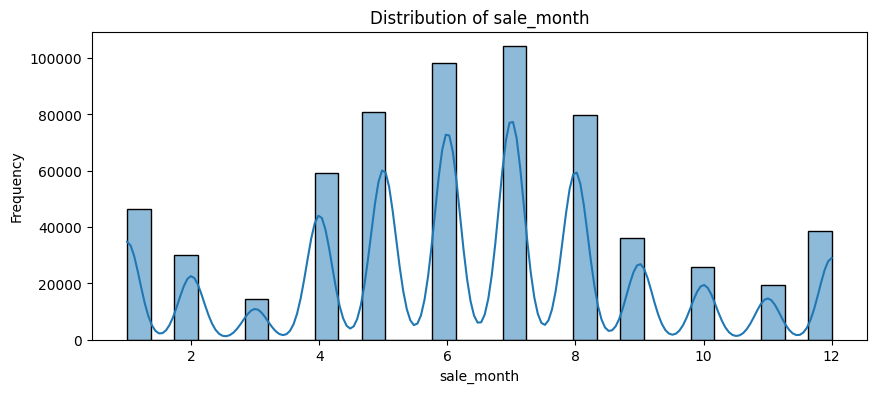

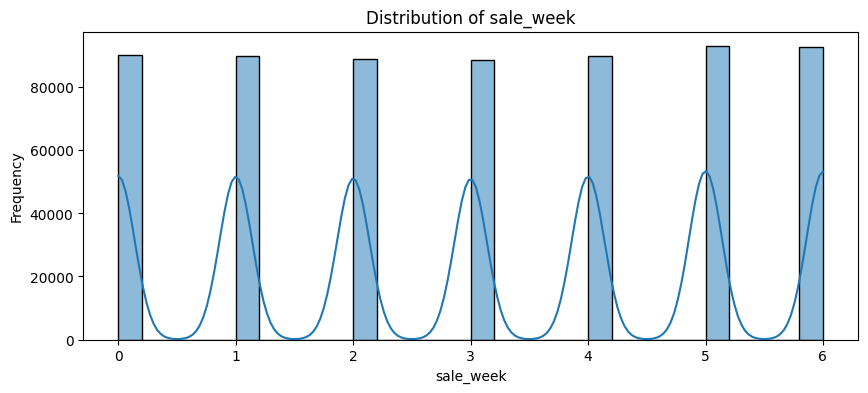

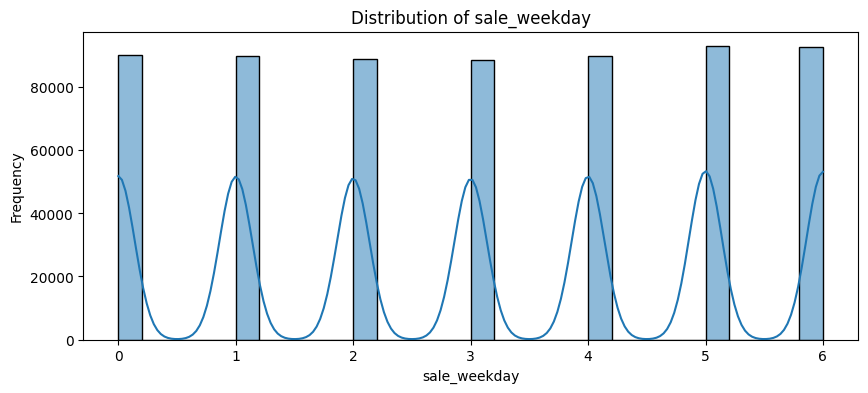

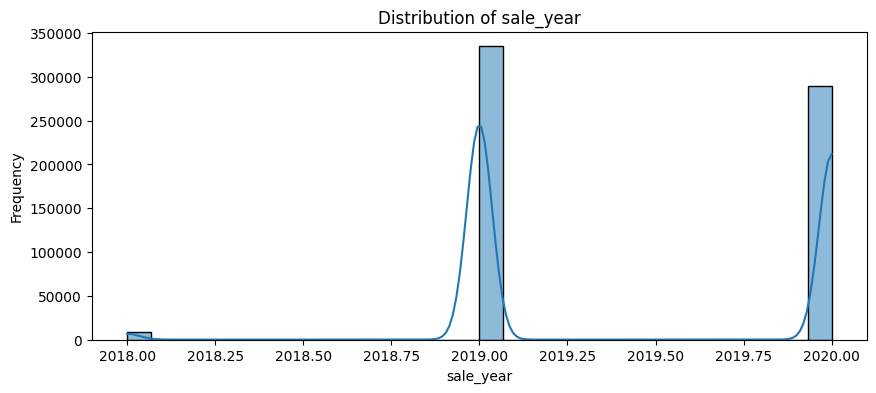

In [13]:
# List of numerical columns to plot
numerical_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
# Create histograms
for column in numerical_columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(train_df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


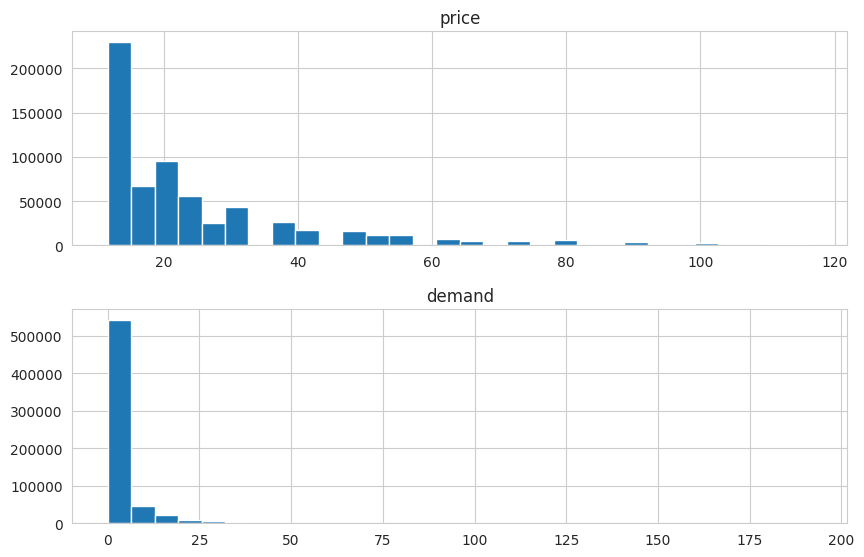

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aesthetic style of the plots
sns.set_style("whitegrid")

# Histograms to understand distributions
train_df[['price', 'demand']].hist(bins=30, figsize=(10, 10), layout=(3, 1))
plt.show()


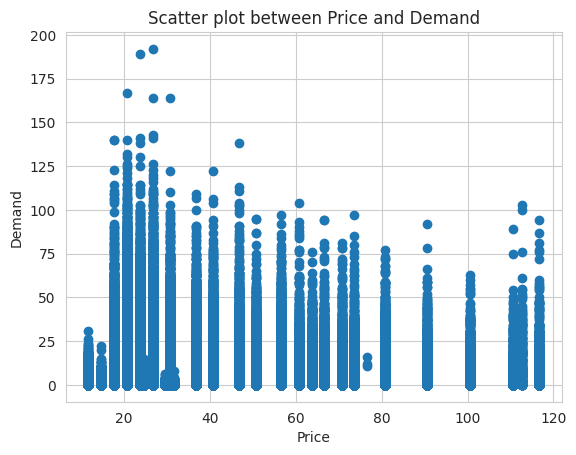

In [15]:
# Scatter plot between Price and Demand
plt.scatter(train_df['price'], train_df['demand'])
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Scatter plot between Price and Demand')
plt.show()


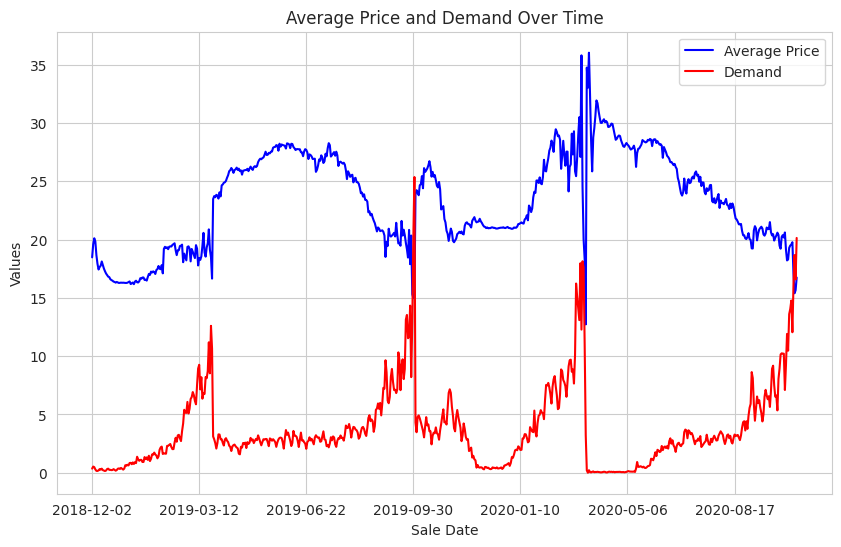

In [16]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Plotting Price over Sale Date
price_plot = train_df.sort_values('sale_date').groupby('sale_date')['price'].mean()
price_plot.plot(label='Average Price', color='blue')

# Plotting Demand over Sale Date
demand_plot = train_df.sort_values('sale_date').groupby('sale_date')['demand'].mean()
demand_plot.plot(label='Demand', color='red')

# Titles and labels
plt.title('Average Price and Demand Over Time')
plt.xlabel('Sale Date')
plt.ylabel('Values')

# Adding a legend to distinguish the plots
plt.legend()

plt.show()


**Visualizing Trends in Price, Demand, and Other Numeric Features Over Time**

These plots are designed to facilitate a multi-dimensional analysis of how various factors evolve together over time. Observing price and demand with other variables simultaneously can uncover patterns that are not apparent when viewing data in isolation. This can be particularly beneficial for spotting economic cycles and understanding market responses.

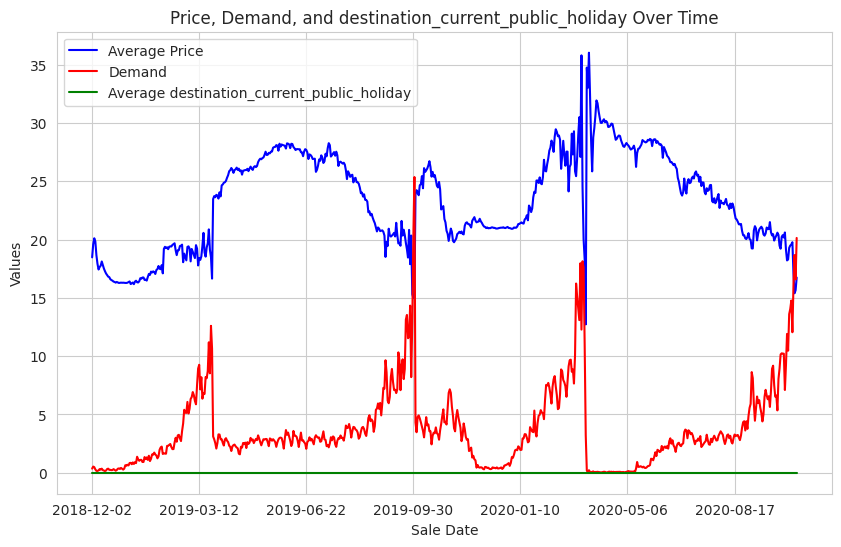

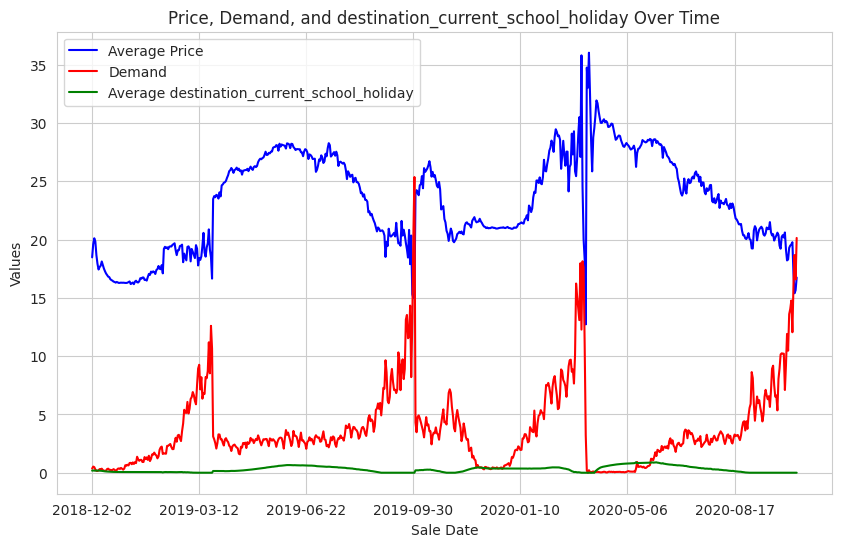

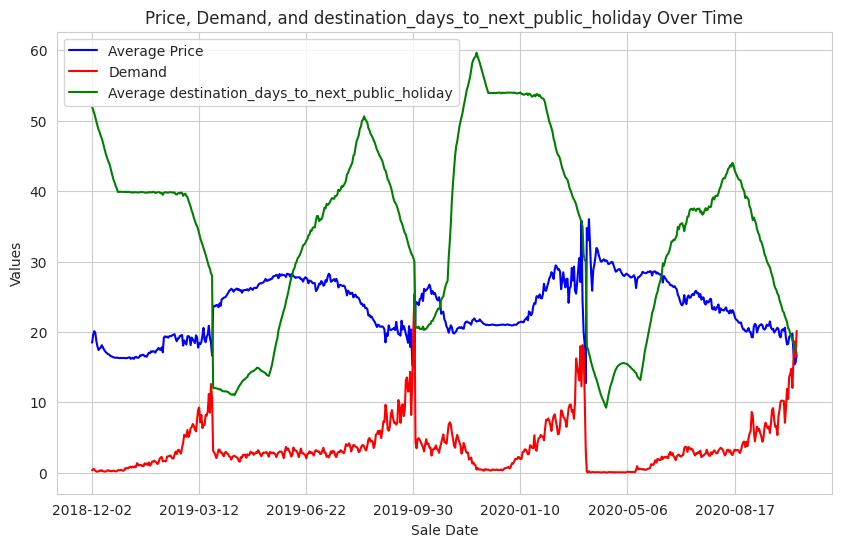

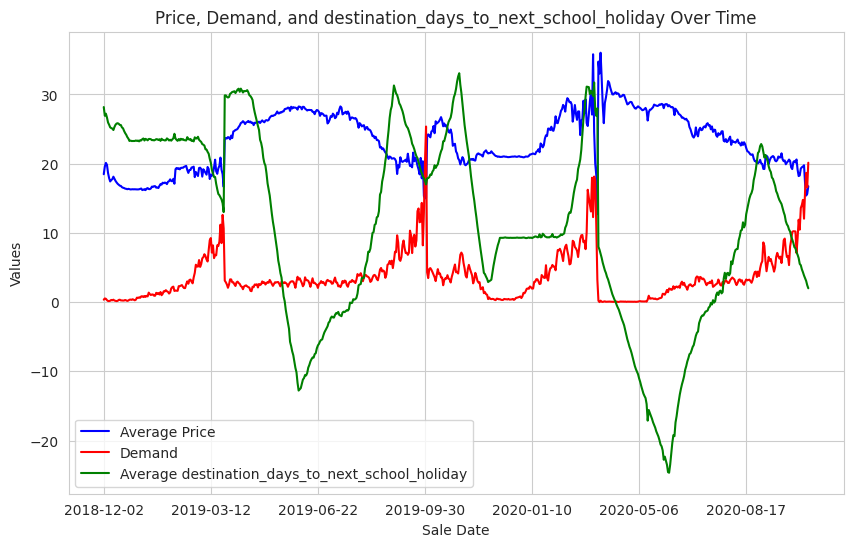

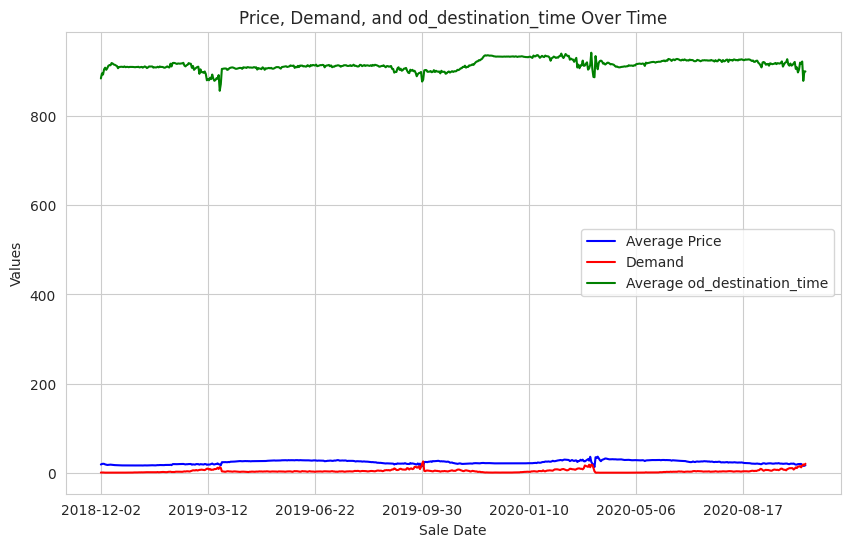

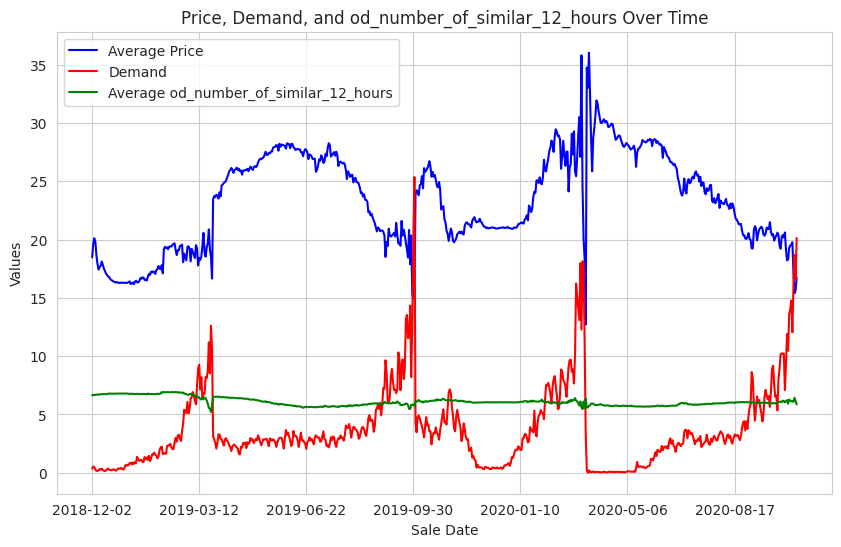

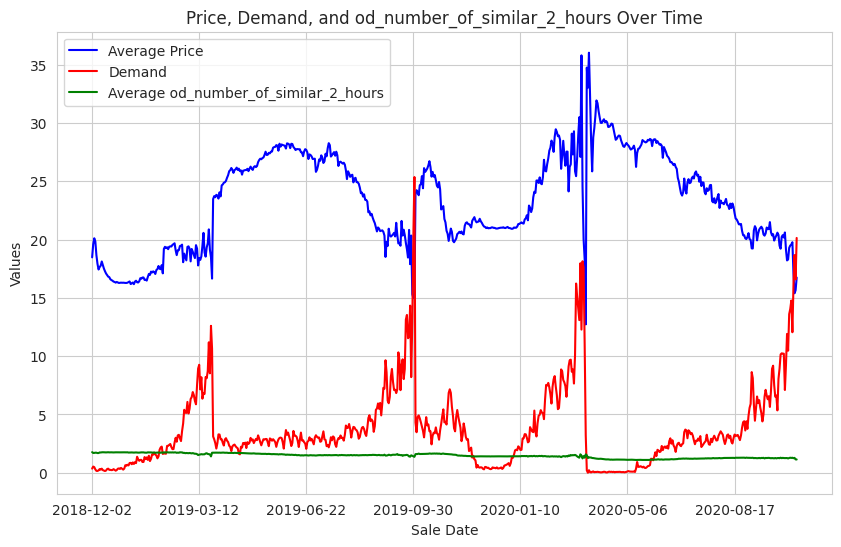

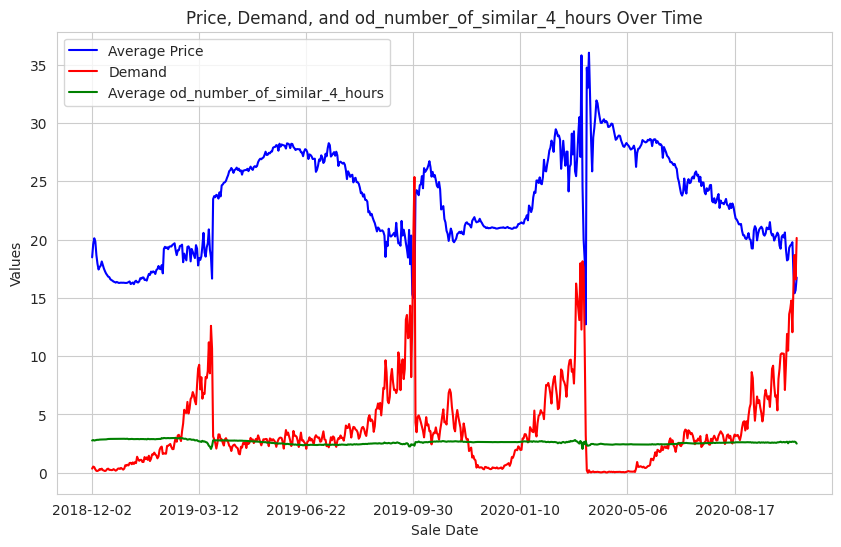

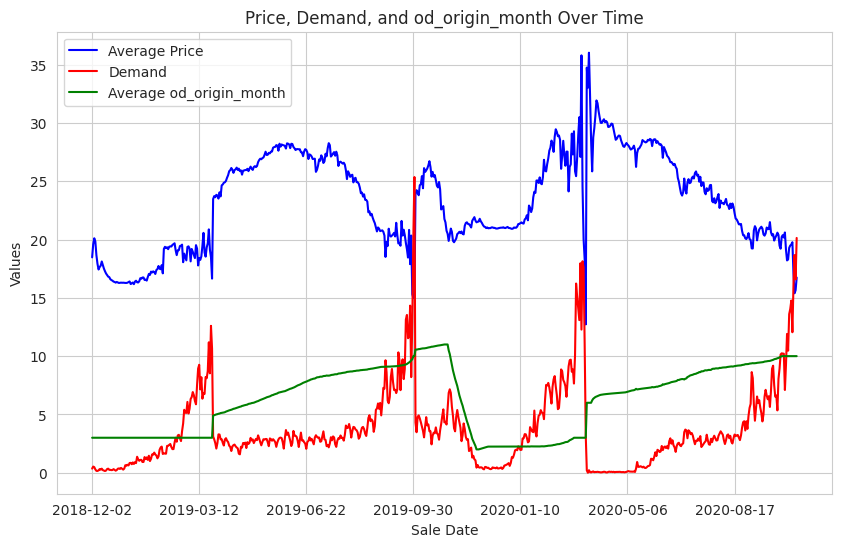

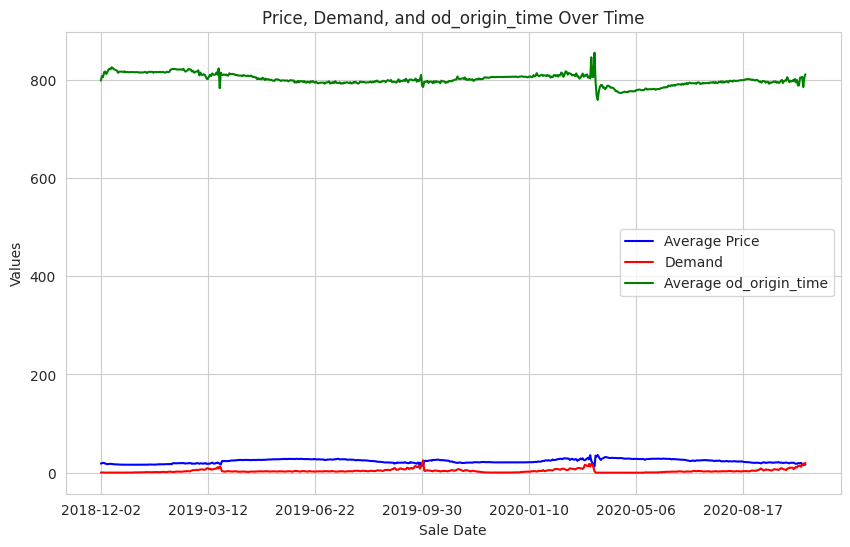

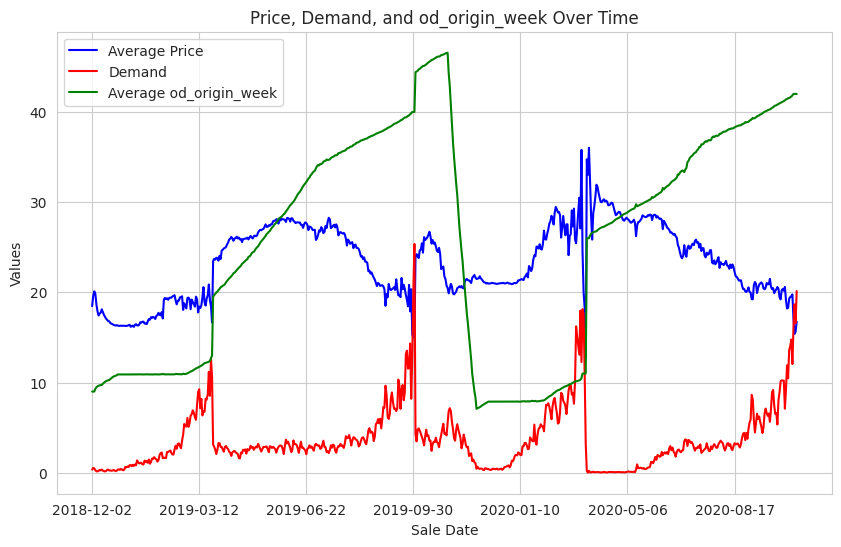

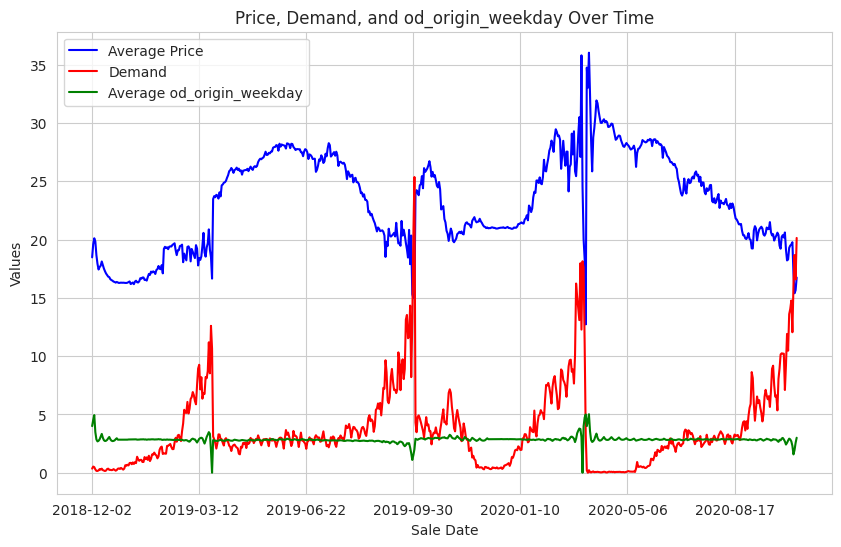

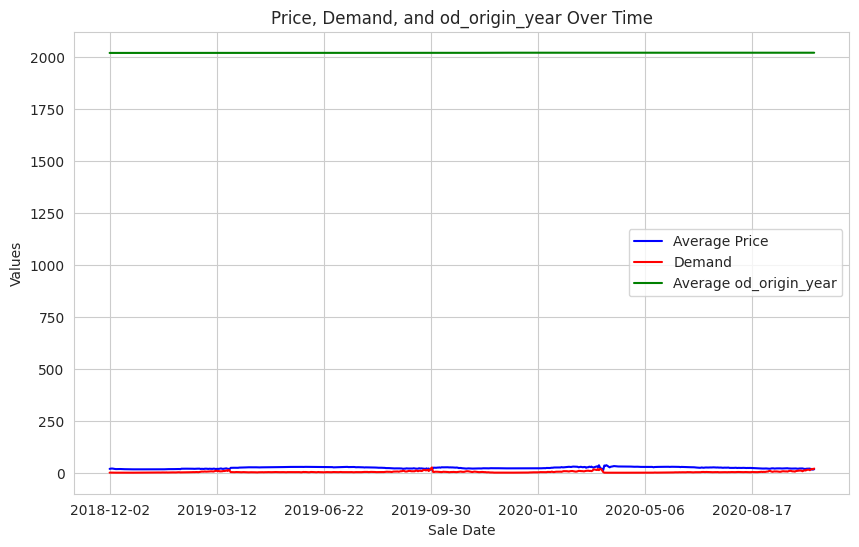

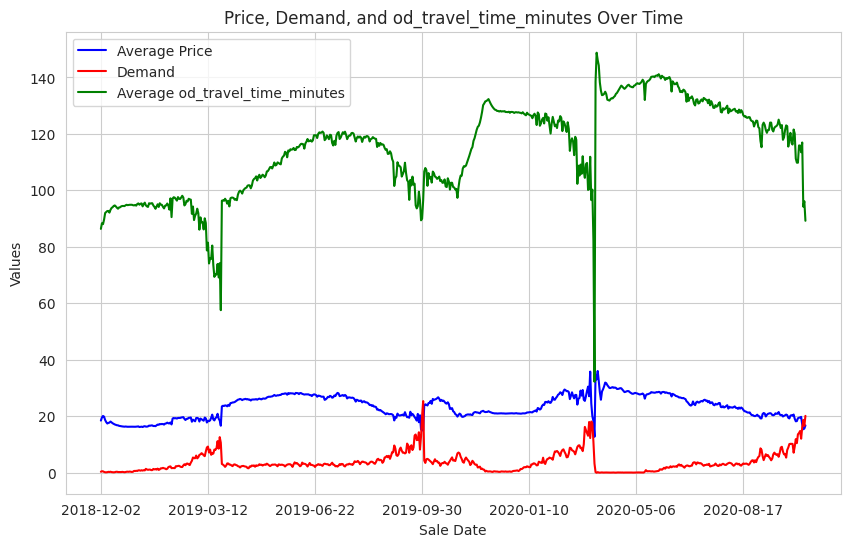

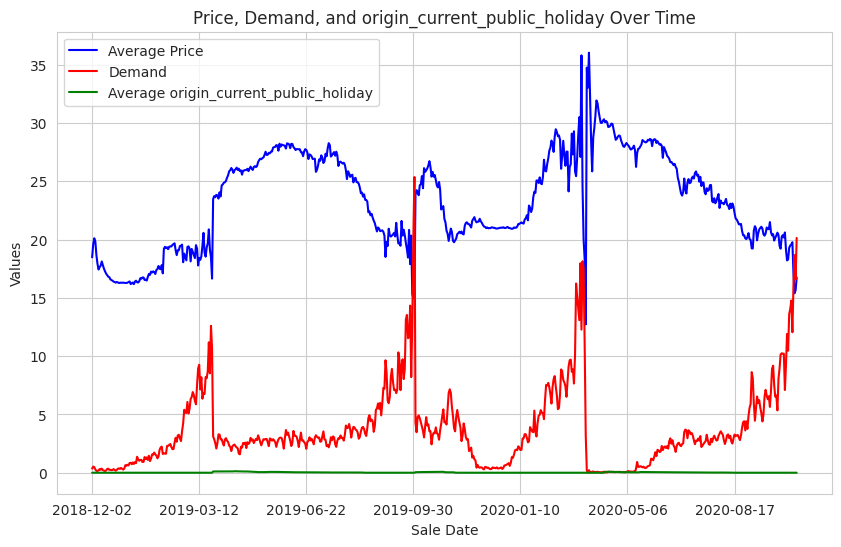

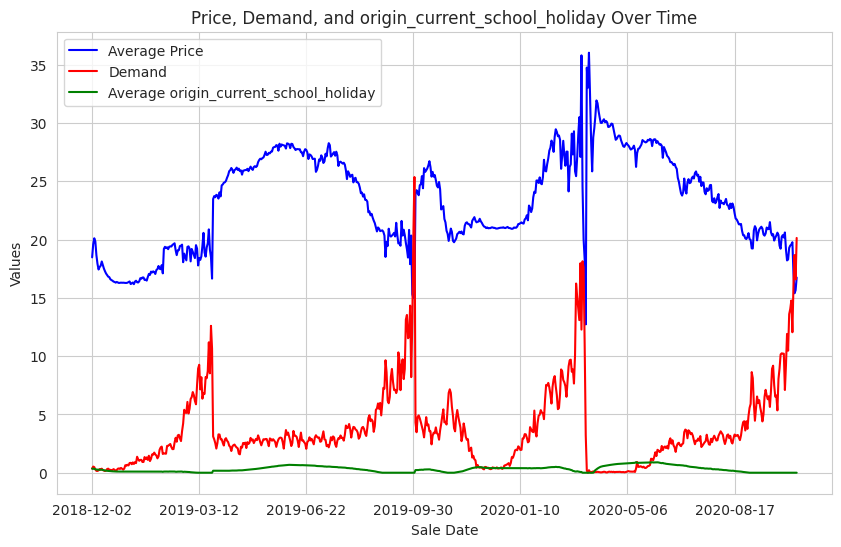

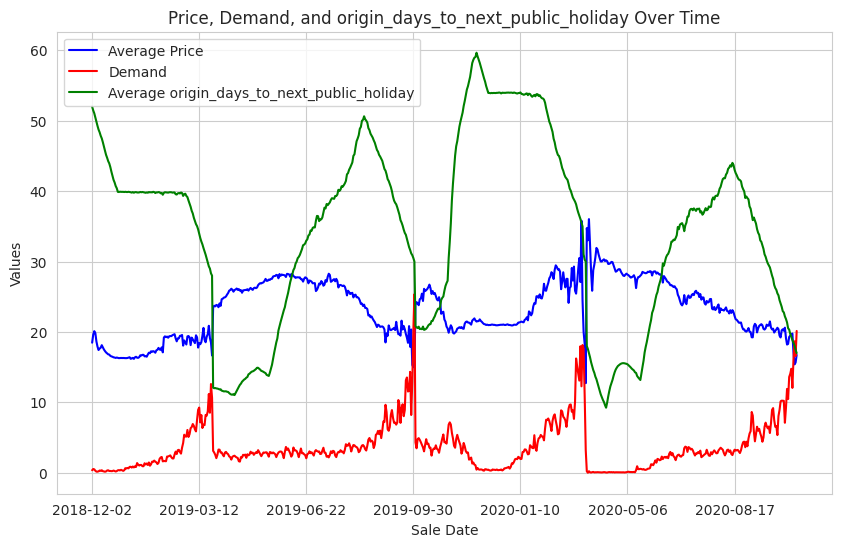

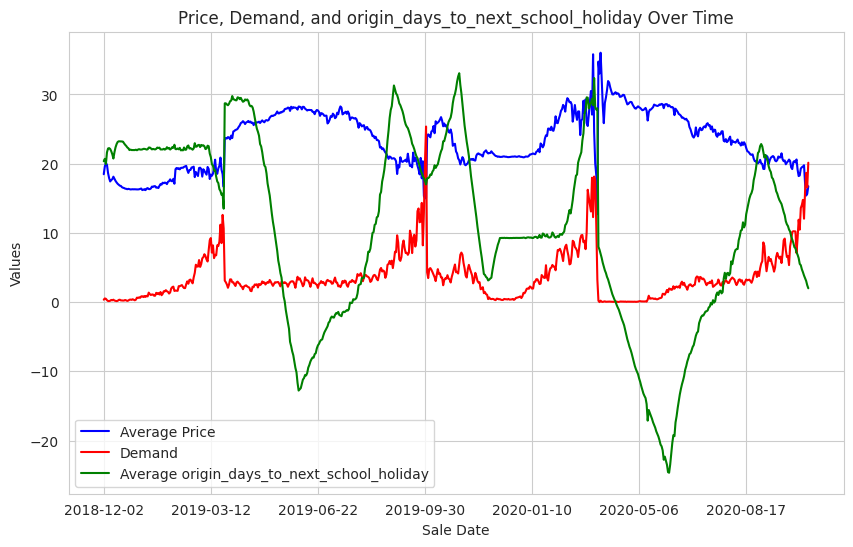

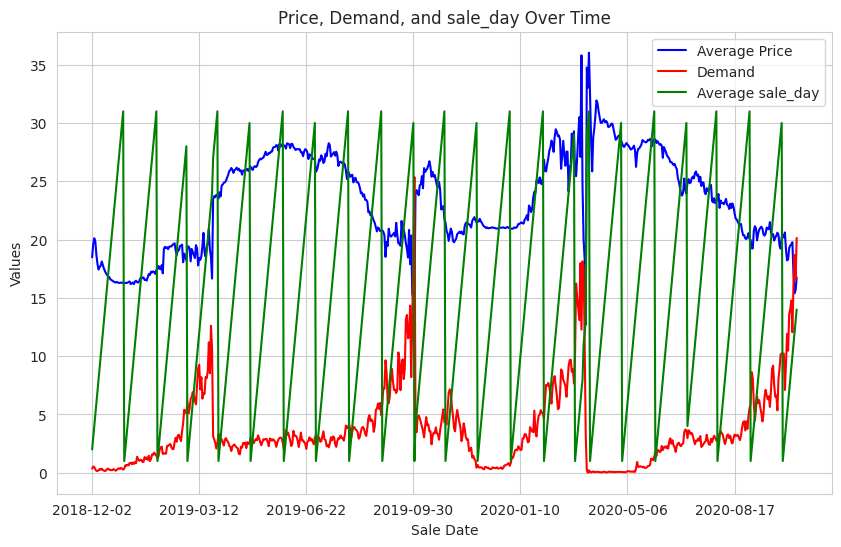

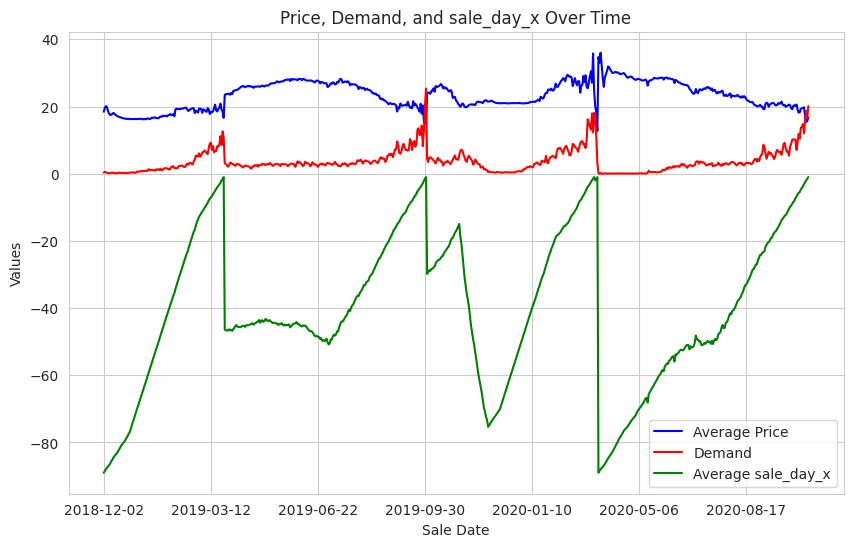

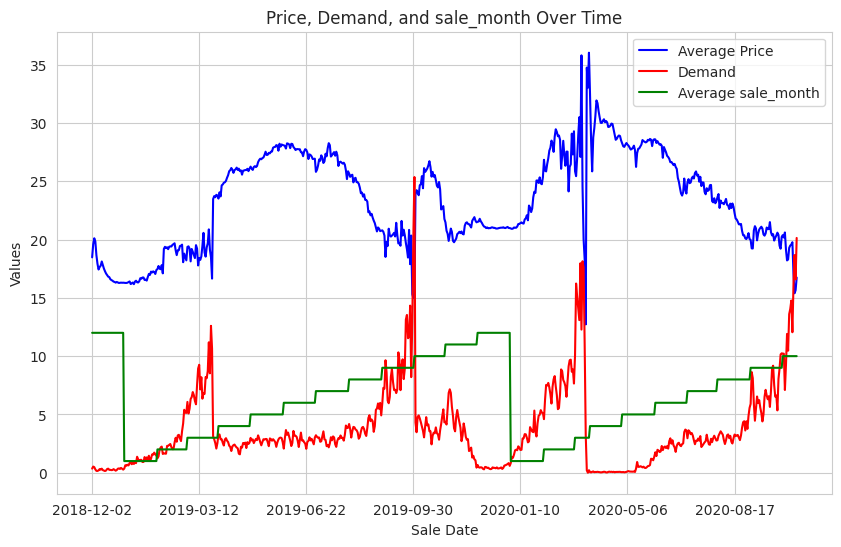

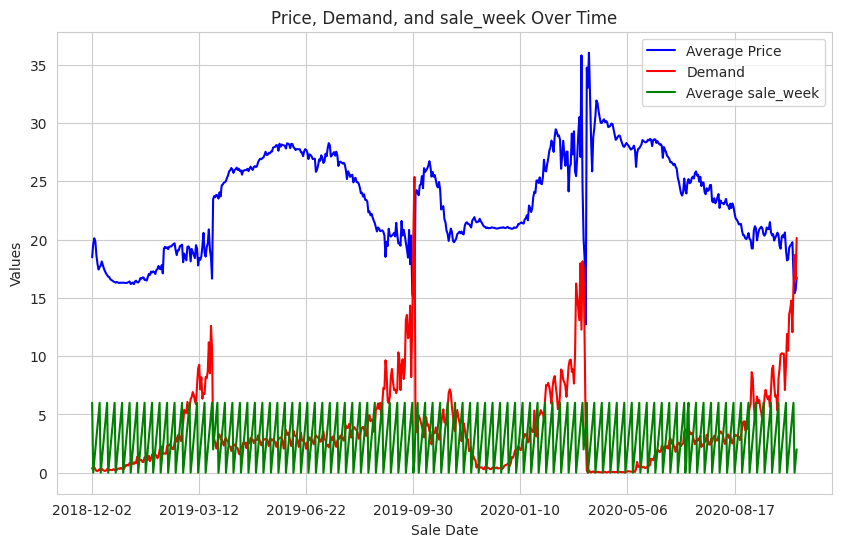

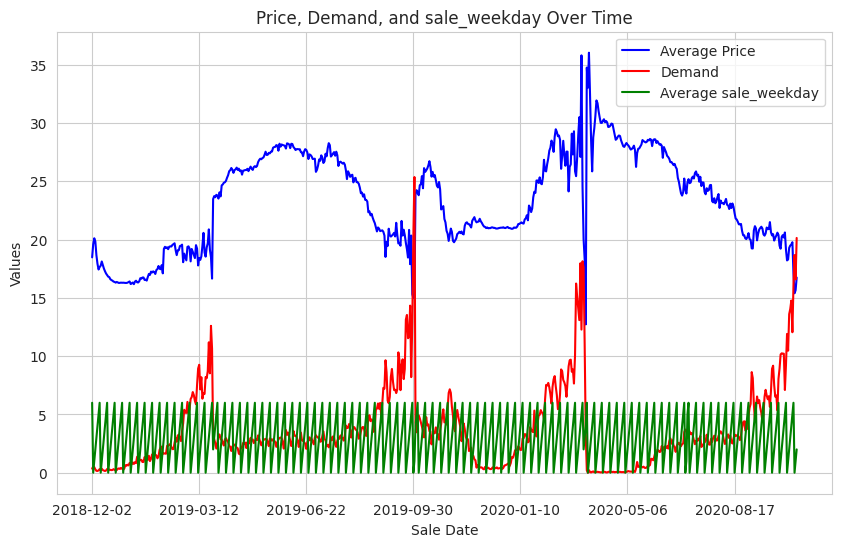

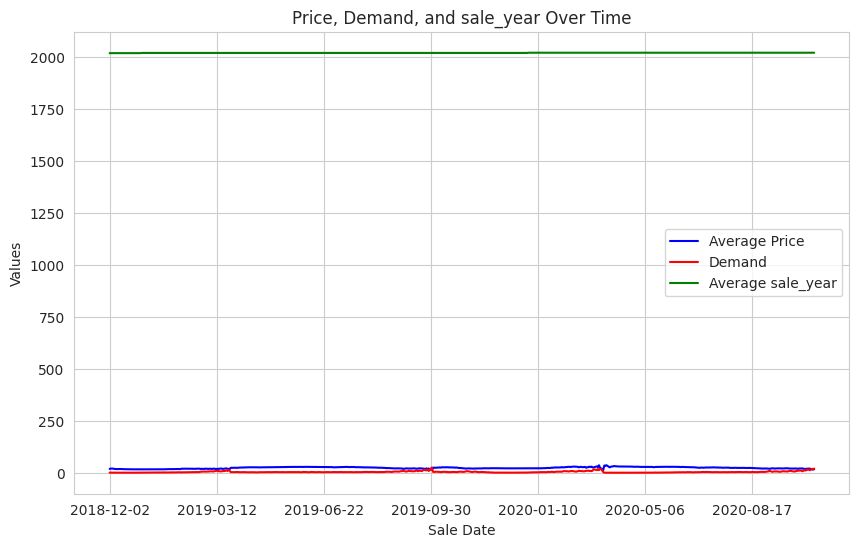

In [17]:
# Filtering out only numeric columns, excluding 'demand' and 'price' since they will be plotted separately
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.drop(['demand', 'price'])

# Sorting the DataFrame by 'sale_date'
train_df.sort_values('sale_date', inplace=True)

for feature in numeric_features:
    plt.figure(figsize=(10, 6))

    # Plotting Price over Sale Date
    price_plot = train_df.groupby('sale_date')['price'].mean()
    price_plot.plot(label='Average Price', color='blue')

    # Plotting Demand over Sale Date
    demand_plot = train_df.groupby('sale_date')['demand'].mean()
    demand_plot.plot(label='Demand', color='red')

    # Plotting additional feature
    if feature in train_df.columns:
        feature_plot = train_df.groupby('sale_date')[feature].mean()
        feature_plot.plot(label=f'Average {feature}', color='green')

        # Adding titles and labels
        plt.title(f'Price, Demand, and {feature} Over Time')
        plt.xlabel('Sale Date')
        plt.ylabel('Values')

        plt.legend()
        plt.show()


In [18]:
train_df_dropped, labels = factorize_columns(train_df, target)
validation_df_dropped, labels = factorize_columns(validation_df, target)

In [19]:
train_df_dropped.head()

demand  departure_date  destination_current_public_holiday  \
0         1               0                                   0   
156       0               0                                   0   
233       0               0                                   0   
322       0               0                                   0   
397       0               0                                   0   

     destination_current_school_holiday  \
0                                     1   
156                                   1   
233                                   0   
322                                   0   
397                                   0   

     destination_days_to_next_public_holiday  \
0                                         52   
156                                       52   
233                                       52   
322                                       52   
397                                       52   

     destination_days_to_next_school_holiday  destination_station_name  \
0                                        -13                         0   
156                                       -6                         1   
233                                       36                         2   
322                                       36                         2   
397                                       36                         2   

     od_destination_time  od_number_of_similar_12_hours  \
0                   1088                              5   
156                 1259                              4   
233                  541                              7   
322                  958                              9   
397                  958                              7   

     od_number_of_similar_2_hours  ...  origin_days_to_next_school_holiday  \
0                               1  ...                                  -6   
156                             3  ...                                 -13   
233                             1  ...                                  36   
322                             4  ...                                  -6   
397                             3  ...                                  36   

     origin_station_name  price  sale_date  sale_day  sale_day_x  sale_month  \
0                      0      0          0         2         -89          12   
156                    1      1          0         2         -89          12   
233                    2      2          0         2         -89          12   
322                    3      3          0         2         -89          12   
397                    2      2          0         2         -89          12   

     sale_week  sale_weekday  sale_year  
0            6             6       2018  
156          6             6       2018  
233          6             6       2018  
322          6             6       2018  
397          6             6       2018  

[5 rows x 30 columns]

In [20]:
train_df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 632841 entries, 0 to 632840
Data columns (total 30 columns):
 #   Column                                   Non-Null Count   Dtype
---  ------                                   --------------   -----
 0   demand                                   632841 non-null  int64
 1   departure_date                           632841 non-null  int64
 2   destination_current_public_holiday       632841 non-null  int64
 3   destination_current_school_holiday       632841 non-null  int64
 4   destination_days_to_next_public_holiday  632841 non-null  int64
 5   destination_days_to_next_school_holiday  632841 non-null  int64
 6   destination_station_name                 632841 non-null  int64
 7   od_destination_time                      632841 non-null  int64
 8   od_number_of_similar_12_hours            632841 non-null  int64
 9   od_number_of_similar_2_hours             632841 non-null  int64
 10  od_number_of_similar_4_hours             632841 non-null  int

The primary goal is to uncover actionable insights that directly impact the target feature. By strategically selecting columns that are most likely to influence the "demand".

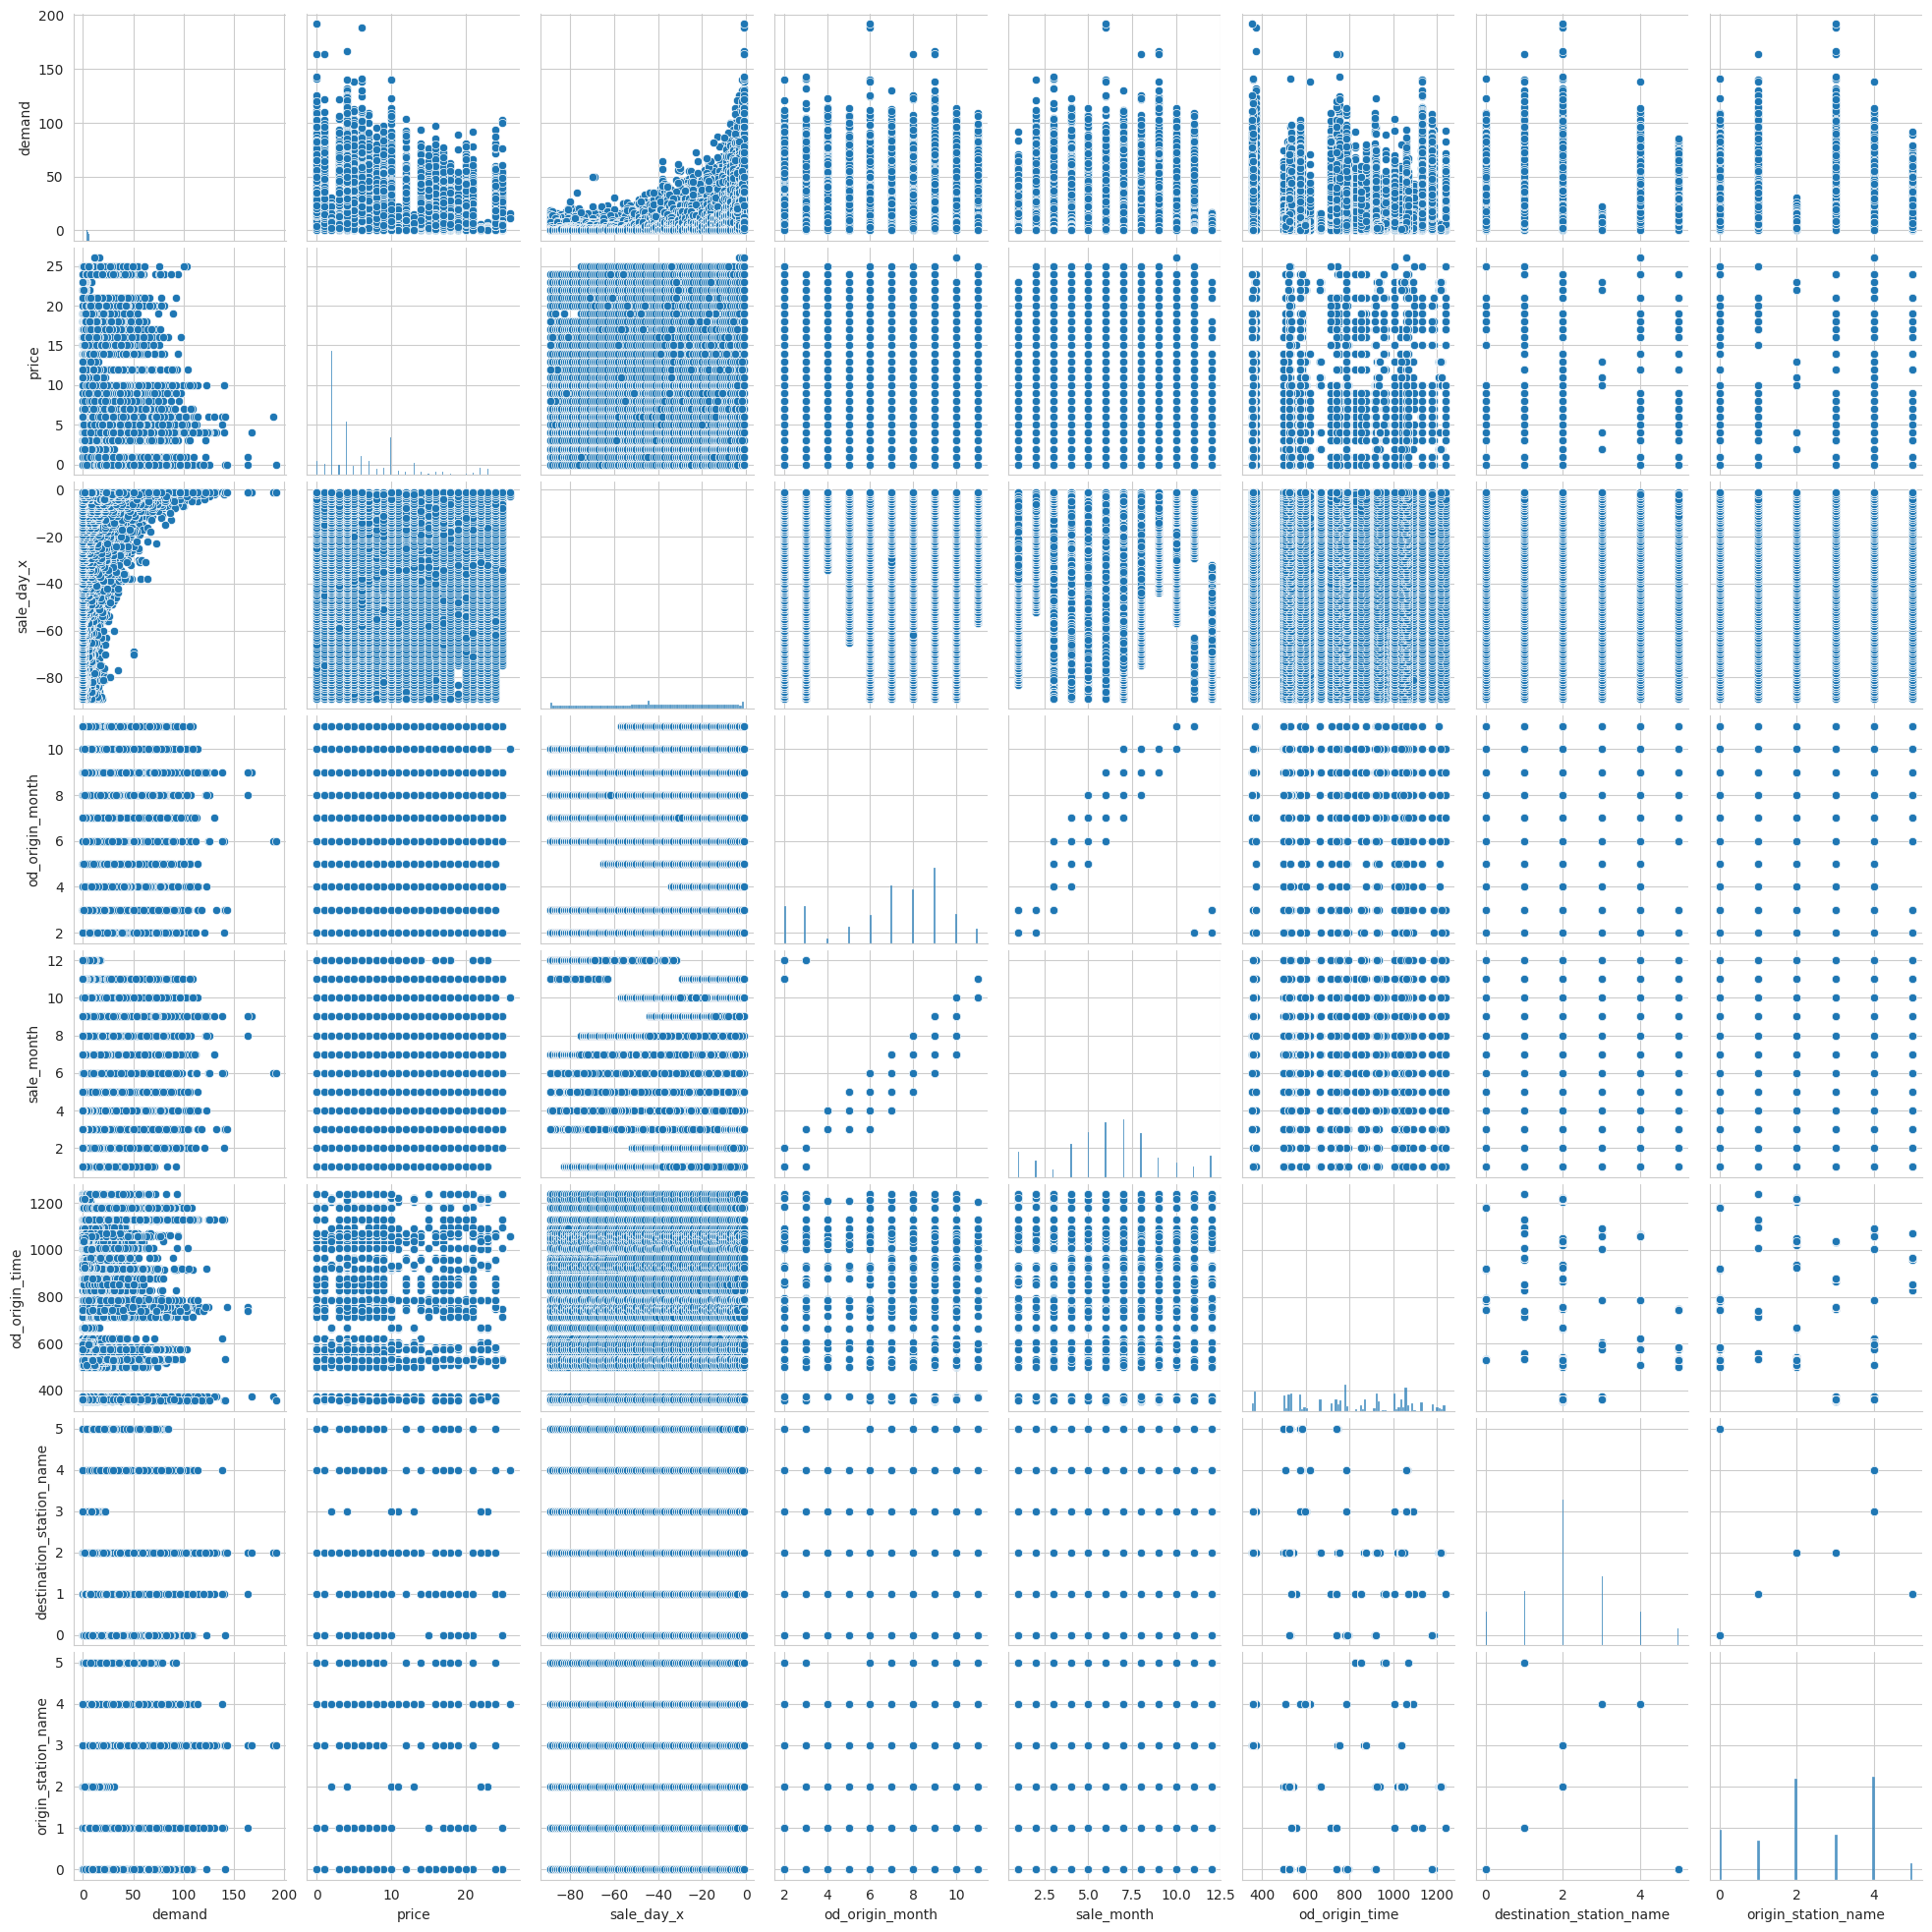

In [21]:
subset_columns = ['demand', 'price','sale_day_x', 'od_origin_month', 'sale_month', 'od_origin_time', 'destination_station_name', 'origin_station_name']
sns.pairplot(train_df_dropped[subset_columns])
plt.show()

In [22]:
train_df_dropped = train_df_dropped.drop(columns=[target])
validation_df_dropped = validation_df_dropped.drop(columns=[target])

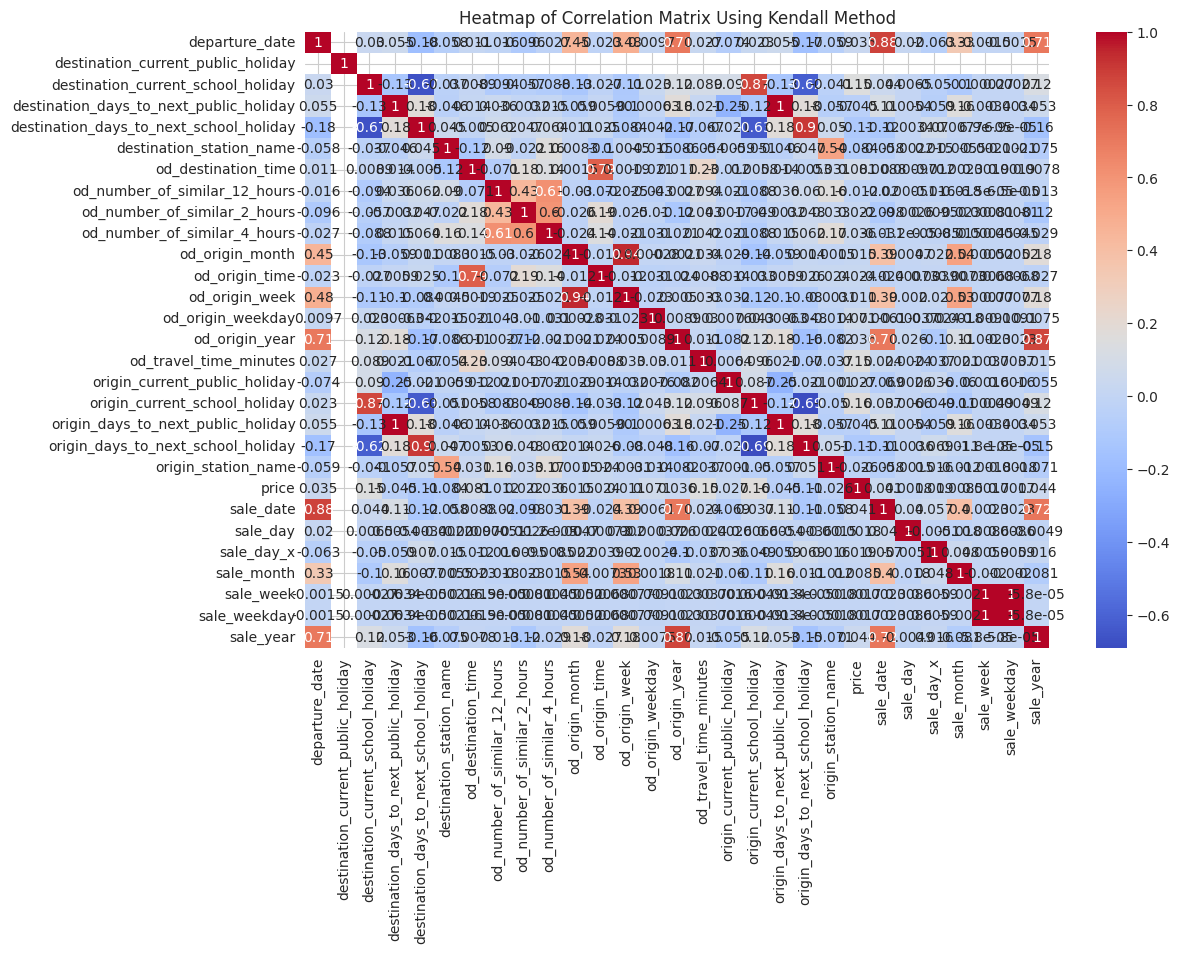

Highly Correlated Features: {'sale_date', 'origin_days_to_next_public_holiday', 'origin_current_school_holiday', 'od_origin_week', 'origin_days_to_next_school_holiday', 'sale_weekday', 'od_origin_time', 'sale_year', 'od_origin_year'}


In [23]:
# Get the highly correlated features
highly_correlated_features = correlation(train_df_dropped, corr_method='kendall', threshold=0.7, show=True, save=True)
print("Highly Correlated Features:", highly_correlated_features)

In [24]:
train_df_dropped = train_df_dropped.drop(columns=highly_correlated_features)
validation_df_dropped = validation_df_dropped.drop(columns=highly_correlated_features)

In [25]:
train_df_dropped = train_df_dropped.drop(columns=['departure_date'])
validation_df_dropped = validation_df_dropped.drop(columns=['departure_date'])

In [26]:
train_df_dropped.columns

Index(['destination_current_public_holiday',
       'destination_current_school_holiday',
       'destination_days_to_next_public_holiday',
       'destination_days_to_next_school_holiday', 'destination_station_name',
       'od_destination_time', 'od_number_of_similar_12_hours',
       'od_number_of_similar_2_hours', 'od_number_of_similar_4_hours',
       'od_origin_month', 'od_origin_weekday', 'od_travel_time_minutes',
       'origin_current_public_holiday', 'origin_station_name', 'price',
       'sale_day', 'sale_day_x', 'sale_month', 'sale_week'],
      dtype='object')

# CNN model

In [27]:
len(train_df_dropped.columns)

19

In [28]:
input_shape = (len(train_df_dropped.columns),1)
filters_in_convs = [128, 512]
kernels_sizes = [3, 3]
strides_sizes = [1, 1]
neurons_in_denses = [512, 256, 128, 64, 32]
activations = ['relu'] * (len(filters_in_convs) + len(neurons_in_denses))

CNN_model = CNN(input_shape, filters_in_convs, kernels_sizes, strides_sizes, neurons_in_denses, activations)

# Compile the model
CNN_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mse'])

# Model summary to show the architecture



In [29]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17, 128)           512       
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 512)           197120    
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 512)               3932672   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [46]:
X = train_df_dropped
y = train_df[target]

seed(1)# Setting a random seed to control randomness, this will ensuring consistent results in each run.

# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
# Train the model
history = CNN_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))#increasing the number of epochs will improve the performance but cnn requires too much training time!

Epoch 1/10
3956/3956 [==============================] - 955s 241ms/step - loss: 1.7323 - mse: 19.0631 - val_loss: 1.5857 - val_mse: 15.0521
Epoch 2/10
3956/3956 [==============================] - 958s 242ms/step - loss: 1.5756 - mse: 15.3947 - val_loss: 1.6116 - val_mse: 16.5088
Epoch 3/10
  13/3956 [..............................] - ETA: 12:55 - loss: 1.6156 - mse: 15.9290

KeyboardInterrupt: 

In [ ]:
CNN_model.save('CNN_model.h5')

**Initial evaluation**

In [97]:
X_new = validation_df_dropped
y_new = validation_df[target]

y_pred = CNN_model.predict(X_new)

mse = mean_squared_error(y_new, y_pred)
mae = mean_absolute_error(y_new, y_pred)
r2 = r2_score(y_new, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

1018/1018 [==============================] - 67s 66ms/step
Mean Squared Error (MSE): 21.051470375771668
Mean Absolute Error (MAE): 1.880158005630131
R-squared: 0.6510847853482387


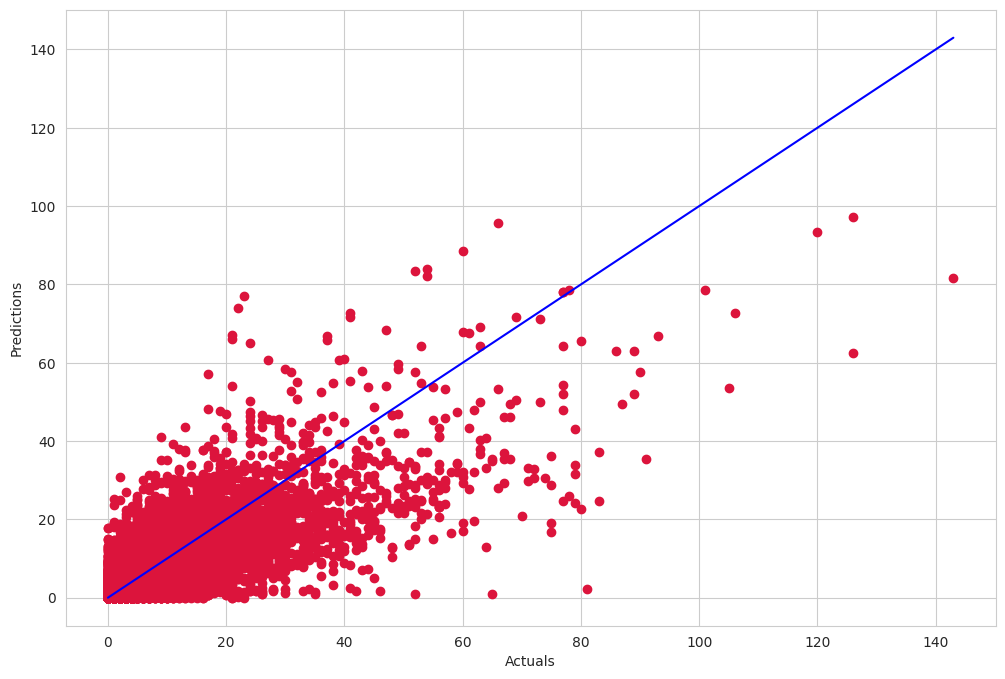

In [35]:
#Scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y_new, y_pred, c='crimson')
ax.plot([y_new.min(), y_new.max()], [y_new.min(), y_new.max()], 'b-')
ax.set_xlabel('Actuals')
ax.set_ylabel('Predictions')
plt.show()

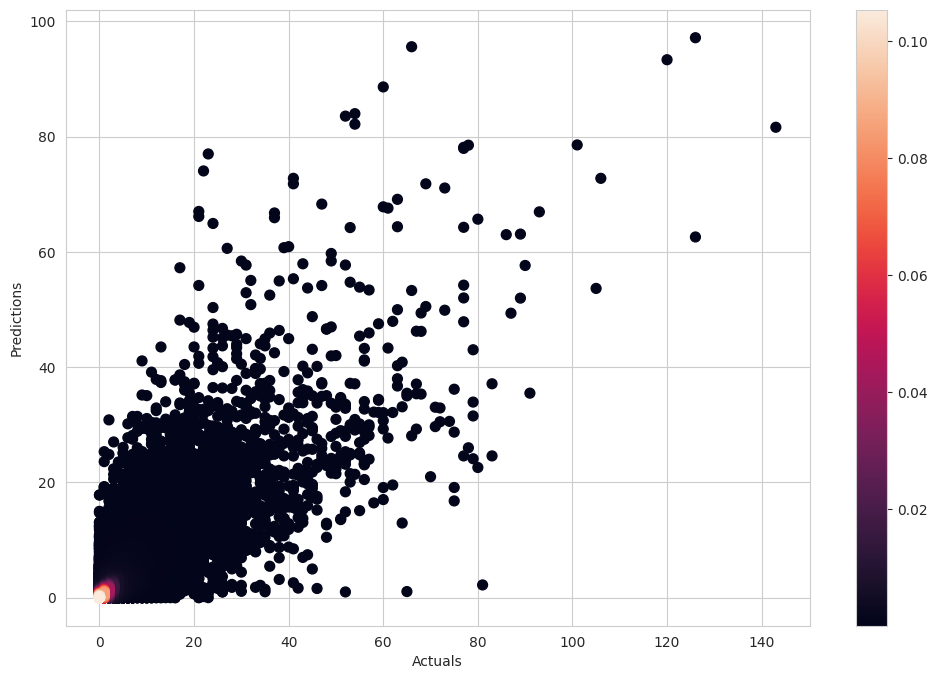

In [36]:
#Heat map
xy = np.vstack([y_new, y_pred.flatten()])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = y_new[idx], y_pred[idx], z[idx]
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlabel('Actuals')
ax.set_ylabel('Predictions')
cax = ax.scatter(x, y, c=z, s=50)
fig.colorbar(cax)
plt.show()

#**Experimenting with different models**

# GradientBoostingRegressor from SKLEARN

In [33]:
seed(1)

GBR_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3)
GBR_model.fit(X_train, y_train)
y_pred = GBR_model.predict(X_test)

In [36]:
X_new = validation_df_dropped
y_new = validation_df[target]

y_pred = GBR_model.predict(X_new)

mse = mean_squared_error(y_new, y_pred)
mae = mean_absolute_error(y_new, y_pred)
r2 = r2_score(y_new, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Mean Squared Error (MSE): 21.794165188701207
Mean Absolute Error (MAE): 2.24506354709821
R-squared: 0.6387750741761248


# LGBMRegressor

In [39]:
import lightgbm as lgb

# Initializing the LGBMRegressor
lgbmr_model = lgb.LGBMRegressor(
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=1000,
    verbose=0
)

lgbmr_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='l1',
)


LGBMRegressor(learning_rate=0.05, n_estimators=1000, verbose=0)

In [40]:
X_new = validation_df_dropped
y_new = validation_df[target]

y_pred = lgbmr_model.predict(X_new)

mse = mean_squared_error(y_new, y_pred)
mae = mean_absolute_error(y_new, y_pred)
r2 = r2_score(y_new, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Mean Squared Error (MSE): 20.789994621249285
Mean Absolute Error (MAE): 2.6233490961754775
R-squared: 0.6554185856665484


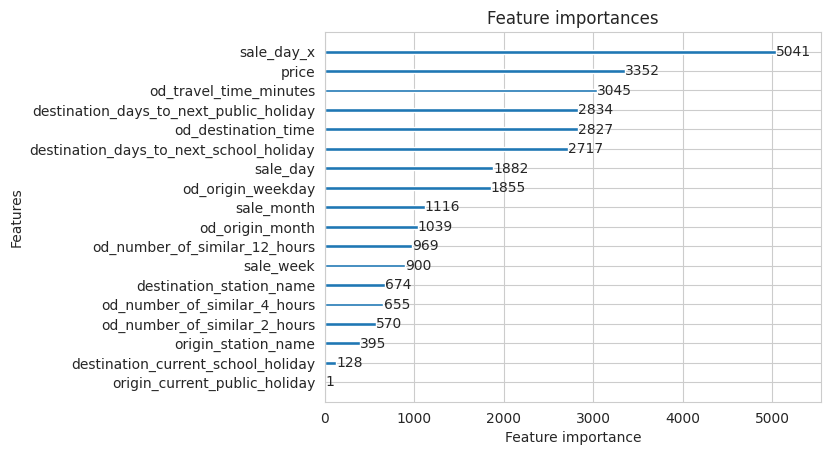

In [41]:
import matplotlib.pyplot as plt

lgb.plot_importance(lgbmr_model, max_num_features=30)
plt.title("Feature importances")
plt.show()

# LightGBM Native API

In [42]:
import lightgbm as lgb
# Creating a LightGBM dataset from the training data
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 50,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
}

# Training the model
num_round = 500
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
X_new = validation_df_dropped
y_new = validation_df[target]

y_pred = bst.predict(X_new, num_iteration=bst.best_iteration)

mse = mean_squared_error(y_new, y_pred)
mae = mean_absolute_error(y_new, y_pred)
r2 = r2_score(y_new, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Mean Squared Error (MSE): 20.023782599251835
Mean Absolute Error (MAE): 2.363805958295117
R-squared: 0.6681180801603719


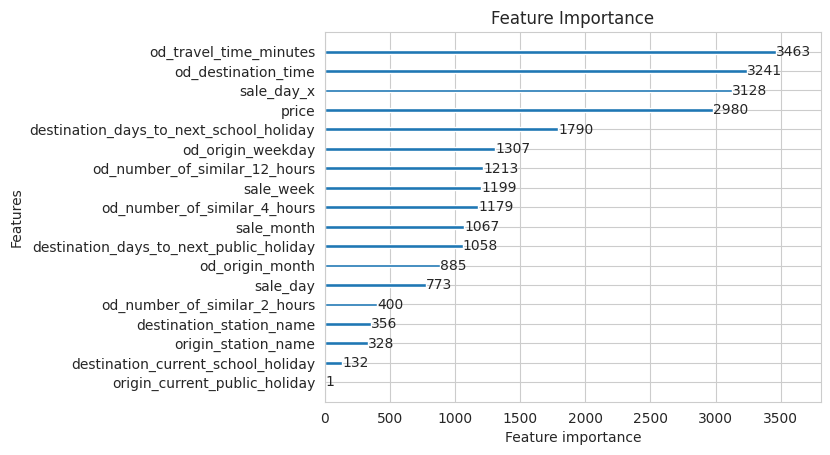

In [44]:
# Feature importance
lgb.plot_importance(bst, max_num_features=30, importance_type='split')
plt.title("Feature Importance")
plt.show()


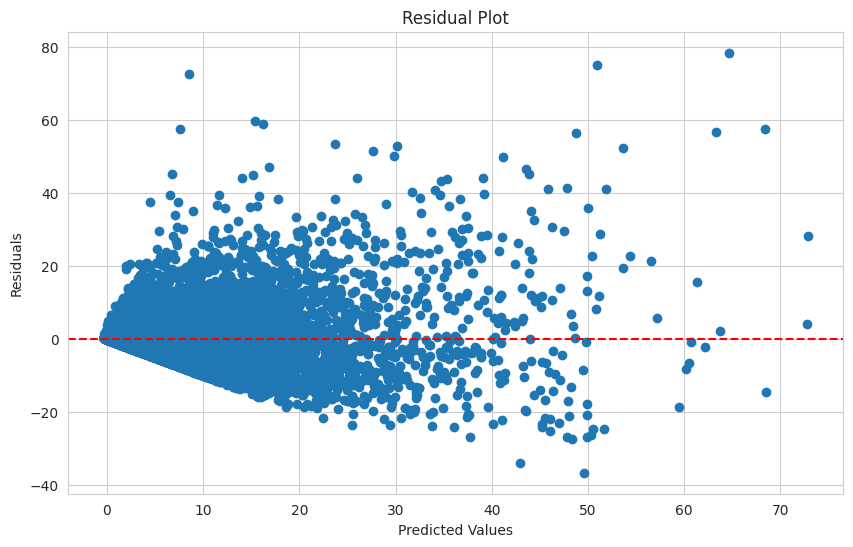

In [45]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_new - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


# Evaluating the CNN model

The CNN seems to be promessing so i focused on further analyzing the model errors on different levels of aggregation

In [37]:
predicted_values = CNN_model.predict(validation_df_dropped)

1018/1018 [==============================] - 19s 18ms/step


In [40]:
# Adding the predictions to the test DataFrame

analysis_df = pd.read_parquet('cayzn_test.parquet')

analysis_df['predicted'] = predicted_values

In [53]:
### Evaluate on sale_date Level
# Grouping the data by date and calculate RMSE, MAE, R^2 for each day
daily_group = analysis_df.groupby(analysis_df['sale_date'])
daily_metrics = daily_group.apply(lambda x: pd.Series({
    'RMSE': np.sqrt(mean_squared_error(x['demand'], x['predicted'])),
    'MAE': mean_absolute_error(x['demand'], x['predicted']),
    'R2': r2_score(x['demand'], x['predicted'])
}))


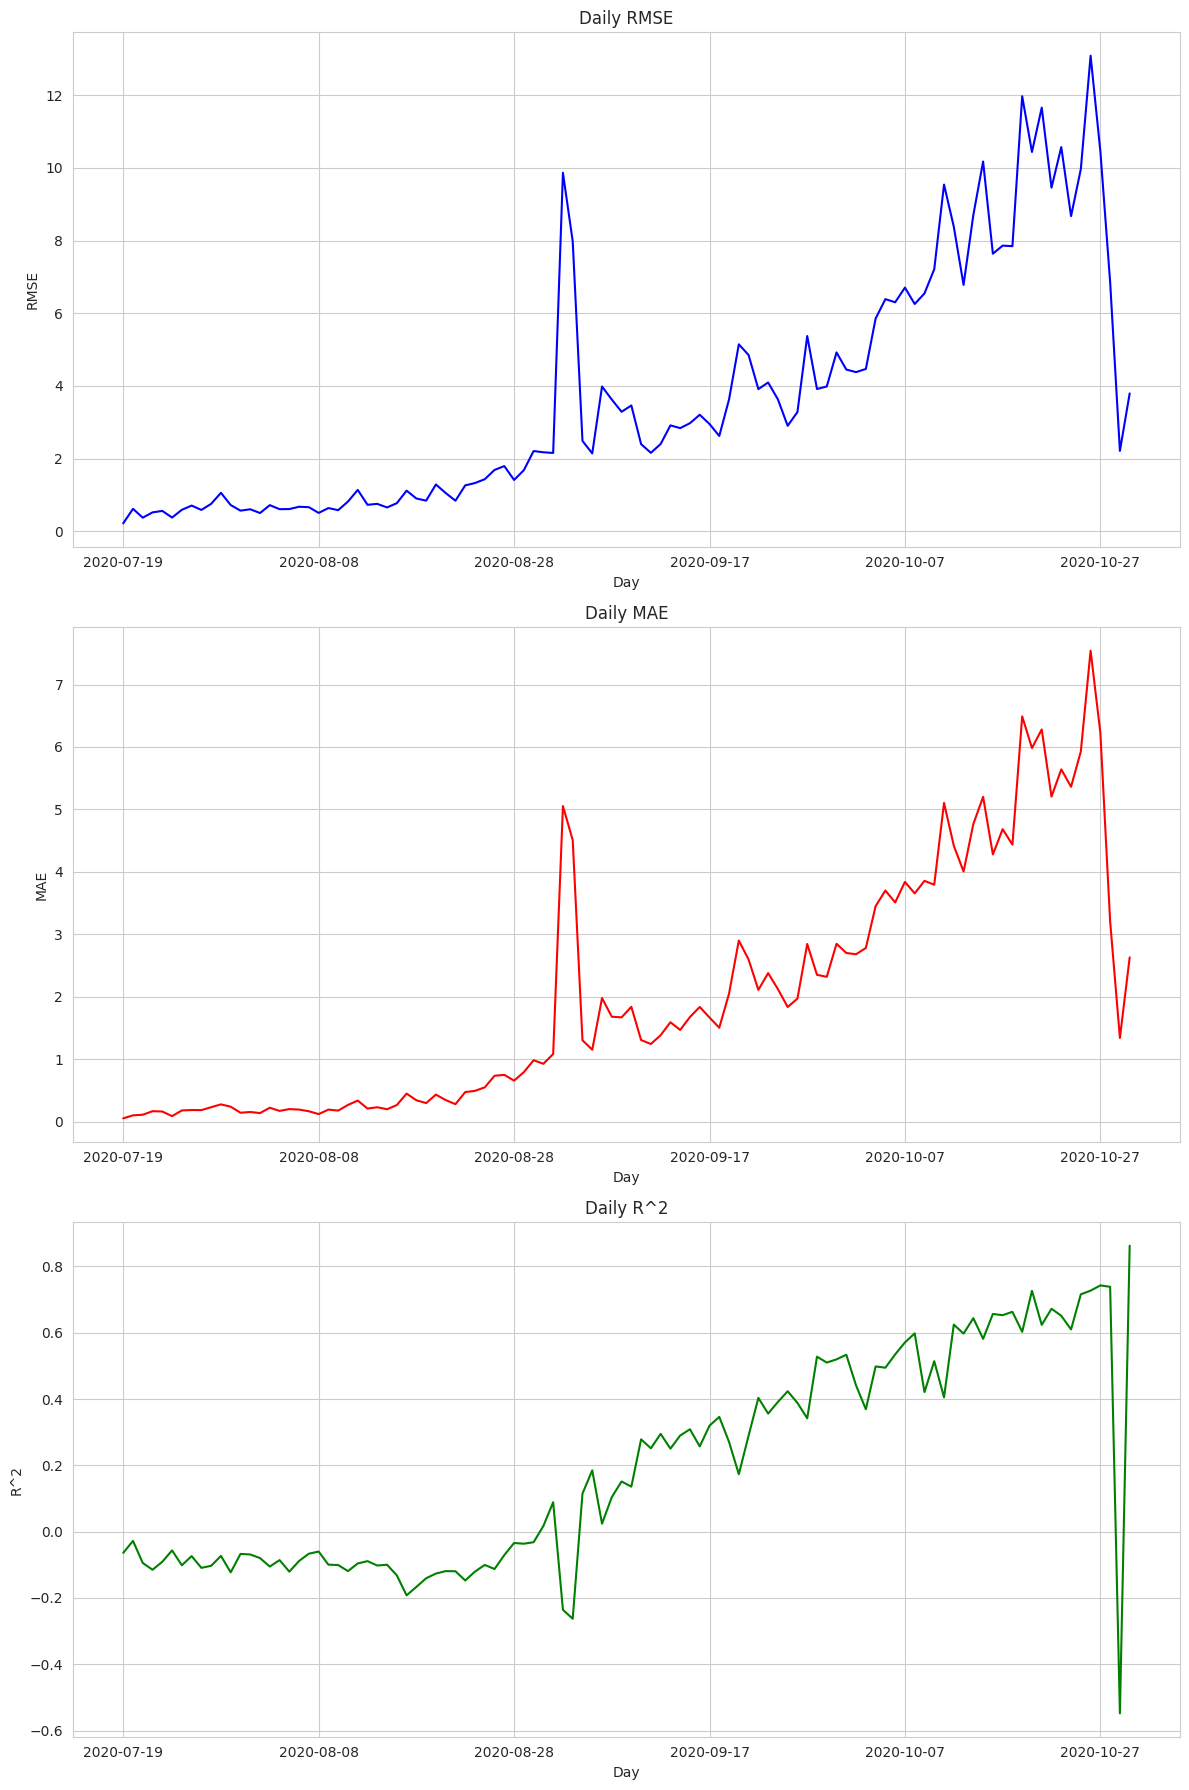

In [54]:
# Plotting daily metrics
fig, ax = plt.subplots(3, 1, figsize=(12, 18))
daily_metrics['RMSE'].plot(ax=ax[0], title='Daily RMSE', color='blue')
ax[0].set_xlabel('Day')
ax[0].set_ylabel('RMSE')

daily_metrics['MAE'].plot(ax=ax[1], title='Daily MAE', color='red')
ax[1].set_xlabel('Day')
ax[1].set_ylabel('MAE')

daily_metrics['R2'].plot(ax=ax[2], title='Daily R^2', color='green')
ax[2].set_xlabel('Day')
ax[2].set_ylabel('R^2')

plt.tight_layout()
plt.show()

In [49]:
### Evaluating on Day_x Level
# Grouping the data by date and calculate RMSE, MAE, R^2 for each day
daily_group = analysis_df.groupby(analysis_df['sale_day_x'])
daily_metrics = daily_group.apply(lambda x: pd.Series({
    'RMSE': np.sqrt(mean_squared_error(x['demand'], x['predicted'])),
    'MAE': mean_absolute_error(x['demand'], x['predicted']),
    'R2': r2_score(x['demand'], x['predicted'])
}))


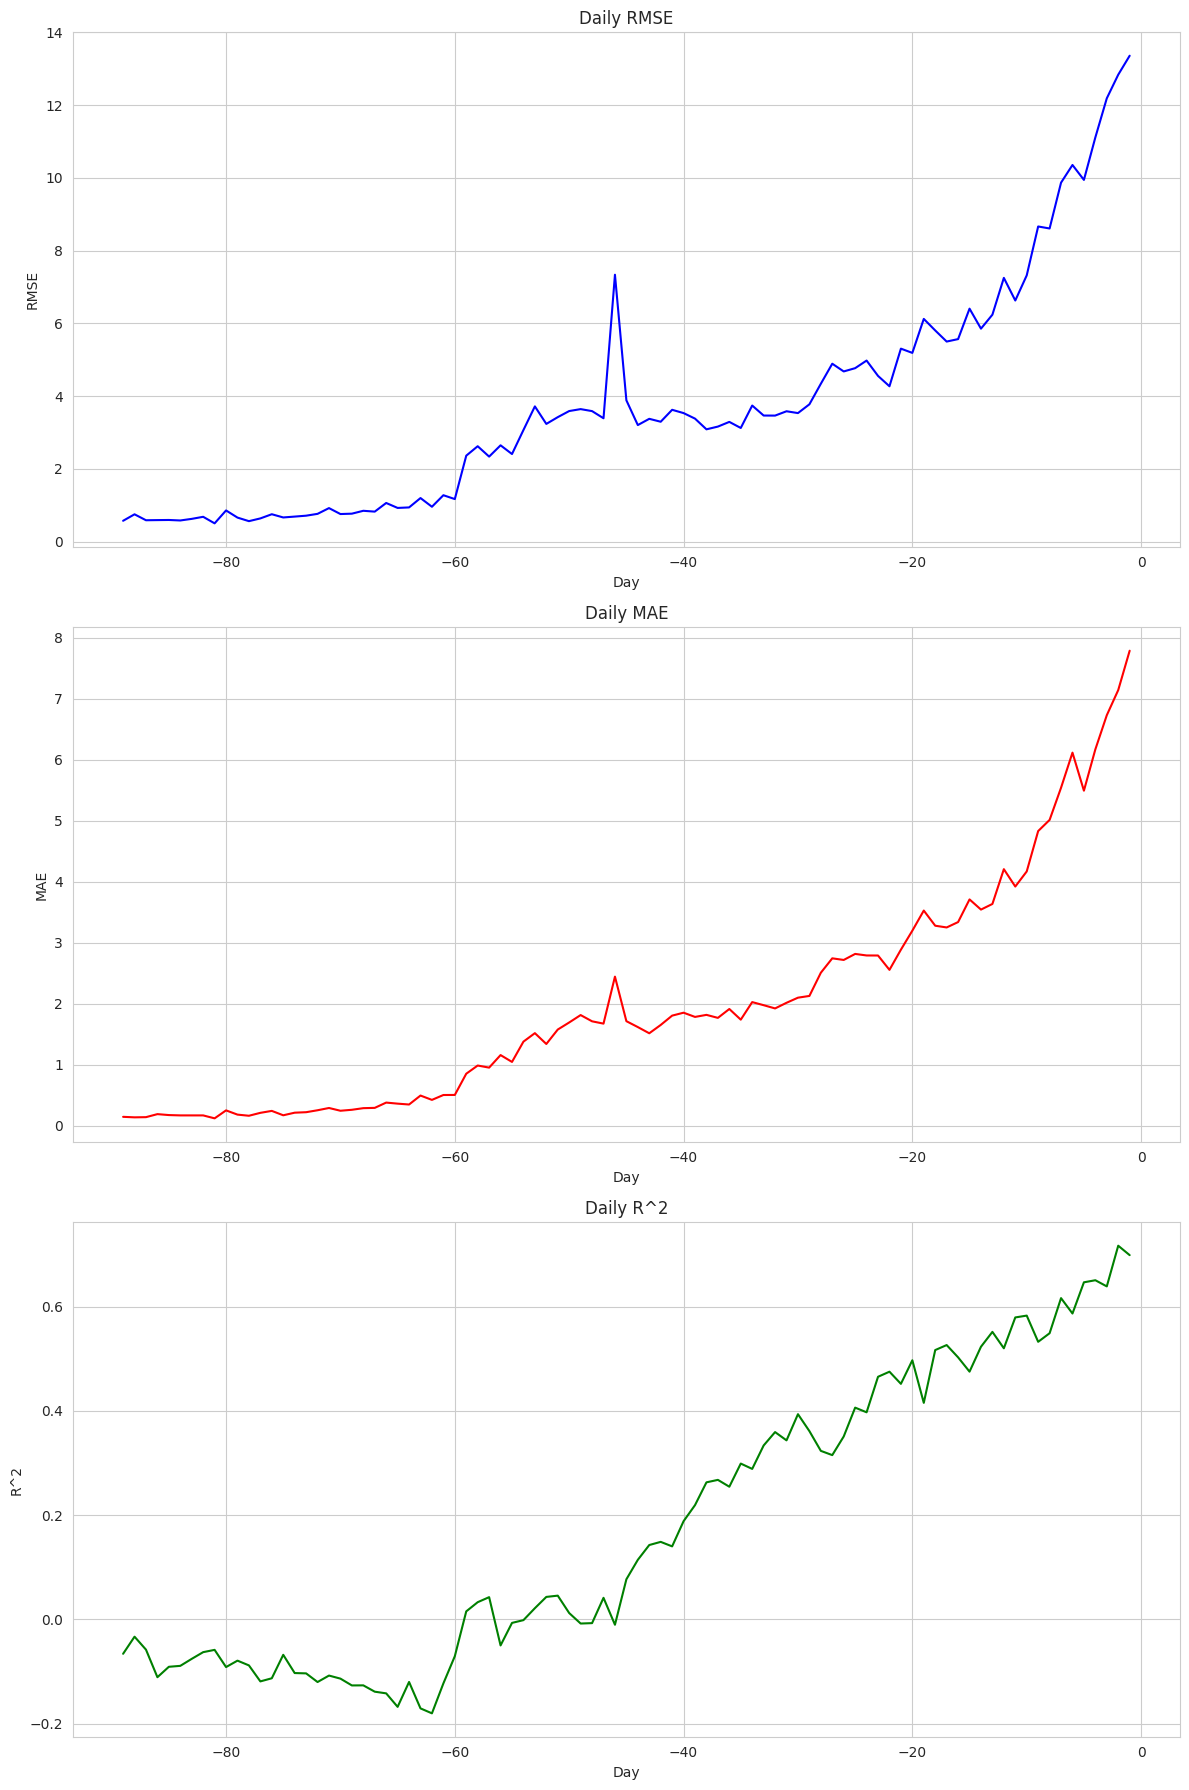

In [50]:
# Plotting metrics
fig, ax = plt.subplots(3, 1, figsize=(12, 18))
daily_metrics['RMSE'].plot(ax=ax[0], title='Daily RMSE', color='blue')
ax[0].set_xlabel('Day')
ax[0].set_ylabel('RMSE')

daily_metrics['MAE'].plot(ax=ax[1], title='Daily MAE', color='red')
ax[1].set_xlabel('Day')
ax[1].set_ylabel('MAE')

daily_metrics['R2'].plot(ax=ax[2], title='Daily R^2', color='green')
ax[2].set_xlabel('Day')
ax[2].set_ylabel('R^2')

plt.tight_layout()
plt.show()

In [61]:
### Evaluating on Origin-Destination Level
# Grouping the data by origin and destination and calculate RMSE, MAE, R^2 for each pair
od_group = analysis_df.groupby(['origin_station_name', 'destination_station_name'])
od_metrics = od_group.apply(lambda x: pd.Series({
    'RMSE': np.sqrt(mean_squared_error(x['demand'], x['predicted'])),
    'MAE': mean_absolute_error(x['demand'], x['predicted']),
    'R2': r2_score(x['demand'], x['predicted'])
}))

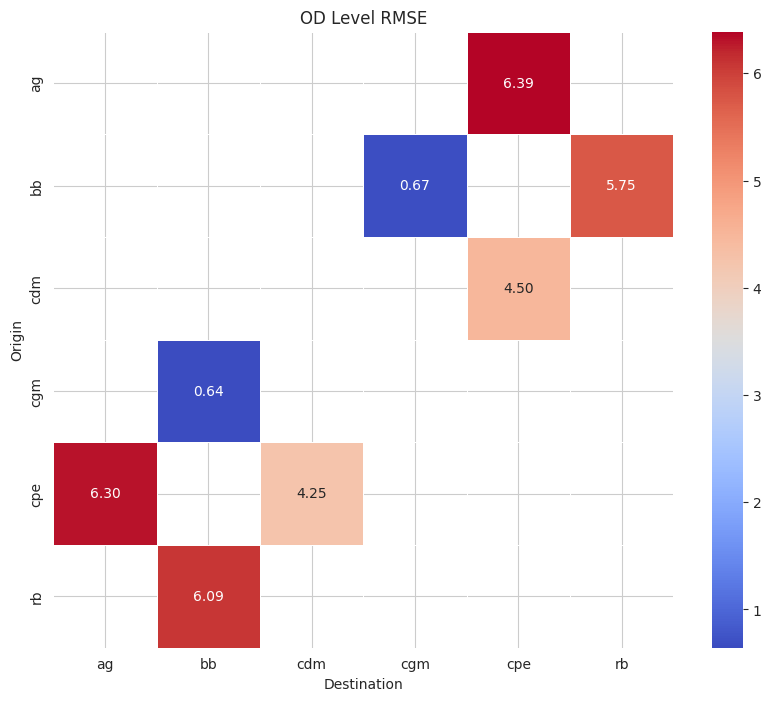

In [62]:
od_metrics = od_metrics.unstack()  # This creates a matrix-like DataFrame where origins are rows and destinations are columns

# Plotting OD Level Performance for RMSE
plt.figure(figsize=(10, 8))
sns.heatmap(od_metrics['RMSE'], annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('OD Level RMSE')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.show()

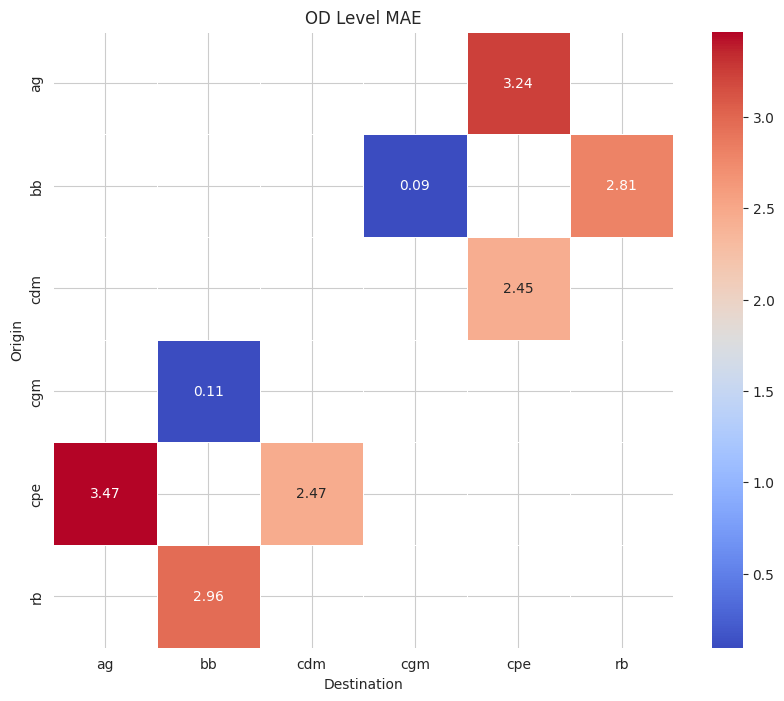

In [63]:
# Plotting OD Level Performance for MAE
plt.figure(figsize=(10, 8))
sns.heatmap(od_metrics['MAE'], annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('OD Level MAE')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.show()

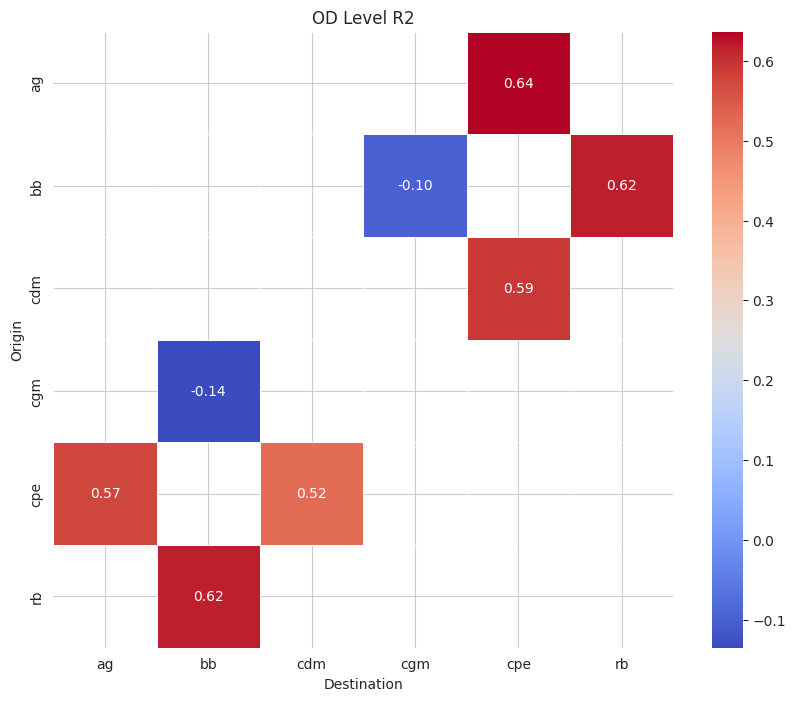

In [64]:
# Plotting OD Level Performance for R2
plt.figure(figsize=(10, 8))
sns.heatmap(od_metrics['R2'], annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('OD Level R2')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.show()

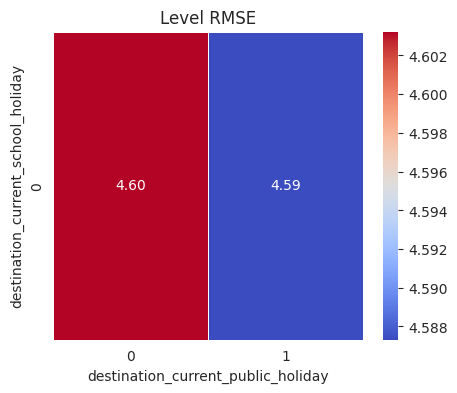

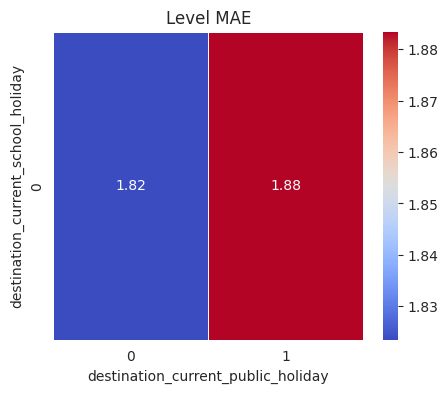

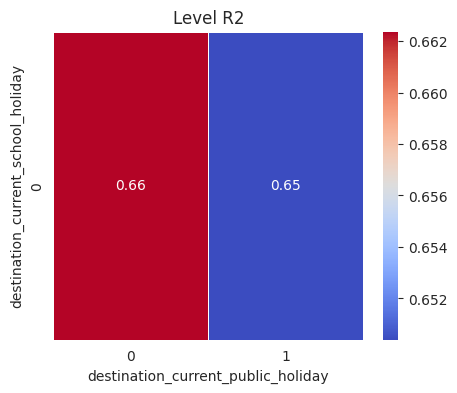

In [82]:
### Evaluating on Origin-Destination Level
# Grouping the data by origin and destination and calculate RMSE, MAE, R^2 for each pair
od_group = analysis_df.groupby(['destination_current_public_holiday', 'destination_current_school_holiday'])
od_metrics = od_group.apply(lambda x: pd.Series({
    'RMSE': np.sqrt(mean_squared_error(x['demand'], x['predicted'])),
    'MAE': mean_absolute_error(x['demand'], x['predicted']),
    'R2': r2_score(x['demand'], x['predicted'])
}))

od_metrics = od_metrics.unstack()

# Plotting Level Performance for RMSE
plt.figure(figsize=(5, 4))
sns.heatmap(od_metrics['RMSE'], annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Level RMSE')
plt.xlabel('destination_current_public_holiday')
plt.ylabel('destination_current_school_holiday')
plt.show()

# Plotting Level Performance for MAE
plt.figure(figsize=(5, 4))
sns.heatmap(od_metrics['MAE'], annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Level MAE')
plt.xlabel('destination_current_public_holiday')
plt.ylabel('destination_current_school_holiday')
plt.show()

# Plotting Level Performance for R2
plt.figure(figsize=(5, 4))
sns.heatmap(od_metrics['R2'], annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Level R2')
plt.xlabel('destination_current_public_holiday')
plt.ylabel('destination_current_school_holiday')
plt.show()

# Shap applied on the CNN model

SHAP (SHapley Additive exPlanations) is a powerful tool for interpreting machine learning models that I've incorporated into this project to enhance the transparency and understanding of our predictive models.

Note on SHAP Value Calculation Time:

The code provided for calculating SHAP values is fully functional, however, please note that the time required to compute these values can increase exponentially with the complexity of the model and the size of the dataset. This increase is due to the intensive computations needed to assess the impact of each feature across many permutations.

In [37]:
%%capture
!pip install shap
import shap

In [ ]:
### since calculating all SHAP in one go can result in file system errors,
### here the calculations are sliced in 3 parts

Sexplainer = shap.DeepExplainer(CNN_model, np.array(train_df_dropped.iloc[0:1000]).reshape(-1, len(train_df_dropped.columns), 1))
for i in range(3):
  if i==2:
    shap_values = Sexplainer.shap_values(np.array(train_df_dropped.iloc[10000*2:]).reshape(-1, len(train_df_dropped.columns), 1))
    sv = pd.DataFrame(shap_values[0],columns=train_df_dropped.columns)
    sv.to_csv("/content/drive/MyDrive/New_Project/PRECISIONdeepSHAP_" + str(i) + ".csv")
    print()
    print(CNN_model.predict(train_df_dropped.iloc[0:1000]).mean())
  else:
    shap_values = Sexplainer.shap_values(np.array(train_df_dropped.iloc[10000*i:10000*(i+1)]).reshape(-1, len(train_df_dropped.columns), 1))
    sv = pd.DataFrame(shap_values[0],columns=train_df_dropped.columns)
    sv.to_csv("/content/drive/MyDrive/New_Project/PRECISIONdeepSHAP_" + str(i) + ".csv")


In [ ]:
sv = pd.DataFrame(columns=train_df_dropped.columns)
for i in range(3):
  temp = pd.read_csv("/content/drive/MyDrive/New_Project/PRECISIONdeepSHAP_" + str(i) + ".csv",index_col=0)
  sv = pd.concat([sv,temp],axis=0)
sv = sv.reset_index(drop=True)
aux = pd.DataFrame(GBR_model.predict(train_df_dropped),columns=['pred'])
SandO = pd.concat([sv,aux],axis=1) # SHAP & model output
# DandO = pd.concat([df,aux],axis=1) # Dataset & output

In [ ]:
#shap.summary_plot(sv.values,X.values,feature_names=X_vars,plot_type='dot',max_display=len(X_vars),)
shap.summary_plot(sv.values,train_df_dropped.values,feature_names=train_df_dropped.columns,plot_type='dot',max_display=15, plot_size=(10,5))